## Meta data

In [53]:
import netCDF4 as nc4
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from tqdm import tqdm
import scipy.ndimage as nd
import scipy.interpolate as interp
from matplotlib.gridspec import GridSpec
import matplotlib.colors as col #ListedColormap
import matplotlib.path as mpp
import h5py  # For NEW Matlab files (AMEDA)
import scipy.io as sio # For OLD Matlab files
from matplotlib import rcParams
import csv
from tools_dyned_these import MLD_threshold
rcParams['pcolor.shading']='auto'

expname='qwa204'  #      <============ Change run name here !

pathdir='/home6/datawork/abarboni/CROCO/TEMP_1km/SAVE_HIS-AVG/'
hisdir='/home6/datawork/abarboni/CROCO/TEMP_1km/SAVE_HIS-AVG/'
#hisdir='/home6/scratch/abarboni/QWA_HIS/'

filename=hisdir+expname+'_his.nc'
avg_name=hisdir+expname+'_avg.nc'
gridname=pathdir+'grd_lat385_1km.nc' #1km_x100.nc'
#crocooutname=pathdir+'croco.out.QWA10'

path_ameda='/home6/datawork/abarboni/CROCO/RESULT/'+expname.upper()+'/'

bulk=True
timestep=2 ## time in day between time step of netcdf _avg file
rg=1 # side padding to reduce data size
depth_m=250  #39 # index of deepest RHO point
depth_surf=20
Xmax=100 # (half) window size in km
mldthres=0.1 # delta threshold =0.1 for temperature

Navg=2   ### 

str_title='Run '+expname.upper()+' - AE CFB 1km ERA5 1-hour '

## Loading data

In [54]:
### Grid   ### MAKE SURE IT IS THE GOOD ONE !
f=nc4.Dataset(gridname)   
x_rho=f['x_rho'][rg:-rg,rg:-rg]/1000 ; y_rho=f['y_rho'][rg:-rg,rg:-rg]/1000
xi_rho=x_rho[0,:]
xmid=int(f.dimensions['xi_rho'].size/2)
f.close()
x_psi=(x_rho[1:,1:]+x_rho[1:,:-1]+x_rho[:-1,1:]+x_rho[:-1,:-1])/4
y_psi=(y_rho[1:,1:]+y_rho[1:,:-1]+y_rho[:-1,1:]+y_rho[:-1,:-1])/4
dx=np.diff(x_rho, axis=1)[0,0]*1000 ; dy=np.diff(y_rho, axis=0)[0,0]*1000 # in meters
x_div=x_rho[1:-1,1:-1] ; y_div=y_rho[1:-1,1:-1]
xi_psi=x_psi[0]

In [55]:
Nt=1 # timestep selection SHOULD BE ONE HERE
### Data
f=nc4.Dataset(avg_name) #filename)
srho=f['s_rho'][:]
H0=f['h'][0,0] ; hc=f['hc'][:]
### Streching coeff
Csr=f['Cs_r'][:] ; sw=f['s_w'][:] ; Csw=f['Cs_w'][:] 
#######z0=hc*srho+(H0-hc)*Csr ## OLD S COORD
z0=H0*(hc*srho+H0*Csr)/(hc+H0) ## NEW S COORD
z_w= H0*(hc*sw+H0*Csw)/(hc+H0) 

time=f['time'][::Nt]/24/3600 #time in days
#zeta=f['zeta'][::Nt,rg:-rg,rg:-rg]            ### BIG DATA
#temp=f['temp'][::Nt,idmax:,rg:-rg,rg:-rg] #temp=f['temp'][::Nt,:,rg:-rg,rg:-rg]
#AKv=f['AKv'][::Nt,idmax:,rg:-rg,rg:-rg]
#W=f['w'][::Nt,-7:,rg:-rg,rg:-rg]#*100*3600 # UNITS = cm/h

qtot=f['shflux'][:,rg:-rg,rg:-rg]       ### FLUXES 
#qsen=f_avg['shflx_sen'][:] ; qsw=f_avg['radsw'][:] ; qlw=f_avg['shflx_rlw'][:]
#qlat=f['shflx_lat'][:,rg:-rg,rg:-rg]
ustr=f['sustr'][:,rg:-rg,rg:-rg] ; vstr=f['svstr'][:,rg:-rg,rg:-rg] # in N/m^2
f.close()

In [56]:
ids=np.argmin(np.abs(z0+depth_surf))
idmax=np.argmin(np.abs(z0+depth_m))
zvert=z0[idmax:] ; z_dzt=z_w[idmax:]
Nvert=len(z0[idmax:]) ; Nx=len(xi_rho) ; Ny=len(xi_rho) ; Ns=len(time) #numb timesteps

In [57]:
f=nc4.Dataset(filename)  ## if Vorticity needed

W=f['w'][int(Navg/2)::Navg,ids,rg:-rg,rg:-rg]

#U=f['u'][int(Navg/2)::Navg,ids,rg:-rg,rg:-rg]      ### near-Surface 
#V=f['v'][int(Navg/2)::Navg,ids,rg:-rg,rg:-rg]
#U_i=f['u'][int(Navg/2)::Navg,id_inter,rg:-rg,rg:-rg] ## Intermediate depth
#V_i=f['v'][int(Navg/2)::Navg,id_inter,rg:-rg,rg:-rg]
f.close()

In [58]:
f=nc4.Dataset(filename)  ## if HIS density needed
f_coriolis=np.mean(f['f'][:])
time_h=f['time'][int(Navg/2)::Navg]/24/3600 #time in days
temp_h=f['temp'][int(Navg/2)::Navg,idmax:,rg:-rg,rg:-rg]

#AKv=f['AKt'][int(Navg/2)::Navg,idmax:,rg:-rg,rg:-rg]
#Eps=f['gls'][int(Navg/2)::Navg,idmax:,rg:-rg,rg:-rg]
f.close()

Nh=len(time_h) ; Nh

389

In [ ]:
f=nc4.Dataset(filename)  ## full depth U/V
U_f=f['u'][int(Navg/2)::Navg,idmax:,rg:-rg,rg:-rg]
V_f=f['v'][int(Navg/2)::Navg,idmax:,rg:-rg,rg:-rg]
f.close()

## Some checks

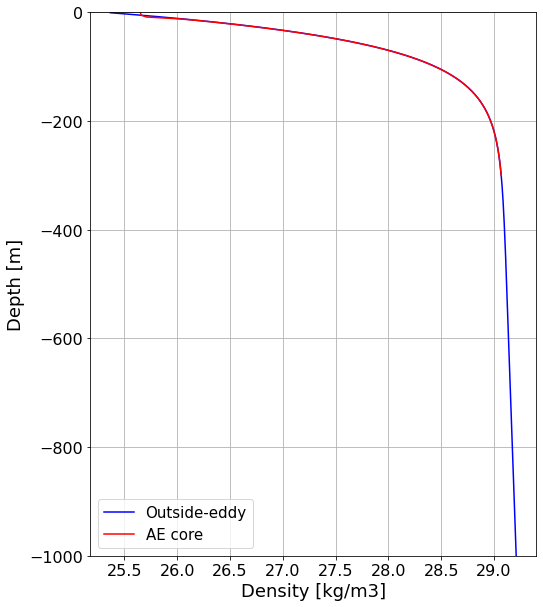

In [8]:
### Initial data
zv=np.arange(-1000,0)
#rho1=1028.95 ; rho0=1024.6 ; ZT=45 ; S=1e-4
rho1=1029.03 ; rho0=1025.3 ; ZT=55 ; S=1.8e-4
rhoini=rho1 - (rho1-rho0)*np.exp(zv/ZT) - S*zv

### Version Slope + Exp sur Temperature
#T1=14.5 ; z1=400 ; T2=17.2 ; T3=30.6 ; Zt=34
#temp_ini=T1 + (T2-T1)*(z1+zv)/z1 + (T3-T2)*np.exp(zv/Zt)
#rho_ini=1000+R0+Tcoef*(T0-temp_ini)

T0=25 ; R0=26 ; Tcoef=0.28 
rho_a=1000+R0+Tcoef*(T0-temp_h[0,:,0,0])


plt.figure(0, figsize=(8,10))
plt.plot(rhoini-1000, zv, '-b', label='Outside-eddy')
plt.plot(rho_a-1000, zvert, '-r', label='AE core') 
plt.legend(loc=3, fontsize=15) ; plt.grid() ; plt.ylim([-1000,0])
plt.xlabel('Density [kg/m3]',size=18)
plt.ylabel('Depth [m]', size=18)
plt.tick_params(labelsize=16)
#plt.savefig('/home6/datahome/abarboni/CROCO/Analysis/IniAeref7.png')

### Reading croco.out. to extract fluxes

In [ ]:
record=0 ; timestf=[] ; STF=[] ; SSF=[] ; wind=[] ; SRF=[] ;  t=0 ; windV=[]
idst_w=17 # or 15 if no V recorded ?
with open(crocooutname, newline='') as csvfile:
    fileread = csv.reader(csvfile, delimiter='\t')
    next(fileread)
    title=next(fileread)[0]
    for row in fileread :
        t+=1
        if record & ((row==[])):
            record=0
        if record :  ### Second test in case of aborted job
            if (row[0][:10]=='          '):
                record=0
        if record:
            if (row[0][:10]!='      WRT_') & (row[0][:10]!='      DEF_') & (row[0][:5]!=' STF>') & (row[0][:5]!=' SRF>') & (row[0][:5]!=' wind') :
                timestf.append(float(row[0][8:20]))
            if (row[0][:10]!='      WRT_') & (row[0][:10]!='      DEF_') & (row[0][:5]==' STF>'):
                STF.append(float(row[0][5:]))
            if (row[0][:10]!='      WRT_') & (row[0][:10]!='      DEF_') & (row[0][:5]==' SRF>'):
                SRF.append(float(row[0][5:]))
            if (row[0][:10]!='      WRT_') & (row[0][:10]!='      DEF_') & (row[0][:10]==' windspd U'): #(row[0][:5]==' wind'):
                wind.append(float(row[0][idst_w:]))
            if (row[0][:10]!='      WRT_') & (row[0][:10]!='      DEF_') & (row[0][:10]==' windspd V'): #(row[0][:5]==' wind'):
                windV.append(float(row[0][idst_w:]))
        if row==[' STEP   time[DAYS] KINETIC_ENRG    POTEN_ENRG    TOTAL_ENRG    NET_VOLUME   trd']:
            record=1
timestf=np.array(timestf) ; STF=np.array(STF)*4185*1026 ; SRF=np.array(SRF)*4185*1026 # Converting in W/m2
SSF=np.array(SSF)*24*365*3600  # Convert in m/year
wind=np.array(wind) ; windV=np.array(windV)

In [6]:
#%% Shaping STF with same size as XX_his.nc time vector 
Nt_f=len(timestf)
Nt_d=int(len(timestf)/6)
STFhis=np.zeros(Nt_f) ; SSFhis=np.zeros(Nt_f) ; windhis=np.zeros(Nt_f) ; SRFhis=np.zeros(Nt_f) ; windVhis=np.zeros(Nt_f)
STFday=np.zeros(Nt_d) ; windday=np.zeros(Nt_d) ; SRFday=np.zeros(Nt_d)
timeflux=np.linspace(timestf[0],timestf[-1],Nt_f) 
dayflux=np.linspace(timestf[0],timestf[Nt_d*6],Nt_d)*2

for i in range(Nt_f):
    id=np.argmin(np.abs(timestf-timeflux[i]))
    SRFhis[i]=SRF[id]
    STFhis[i]=STF[id]
    windhis[i]=wind[id]
    windVhis[i]=windV[id]
windTothis=np.sqrt(windhis**2+windVhis**2)

for i in range(Nt_d):
    STFday[i]=np.mean(STF[i*12:(1+i)*12])
    SRFday[i]=np.mean(SRF[i*12:(1+i)*12])
    windday[i]=np.mean(windTothis[i*12:(1+i)*12])
    
Qmean=STFday ; Wspeed=windday ## to match with Bulk version
plt.figure(0, figsize=(8,10))
plt.subplot(311) ; plt.grid(); plt.xlim([0,10])
plt.plot(timeflux,STFhis,'-r')
plt.plot(dayflux,Qmean,'--r')
plt.ylabel('Total Flux \n(W/m2)', size=16) #; plt.xlabel('Time (days)', size=18)
plt.subplot(312) ; plt.grid()  
plt.plot(timeflux,windhis,'--g', label='Zonal');
plt.plot(dayflux,Wspeed,'--k', label='daily');
plt.plot(timeflux,windTothis,'-g', label='Total'); plt.xlim([0,10])
plt.ylabel('Wind (m/s)',size=16) ; plt.legend()
plt.subplot(313) ; plt.grid() ; plt.xlim([0,10])
plt.plot(timeflux,SRFhis,'-k')
plt.ylabel('Short Wave \n(W/m2)',size=16) ; plt.xlabel('Time (days)', size=18)

NameError: name 'timestf' is not defined

In [ ]:
plt.imshow(qtot[90]) ; plt.colorbar()
Qmean=np.mean(qtot, axis=(1,2)) ; Qmin=np.min(qtot, axis=(1,2)) ; Qmax=np.max(qtot, axis=(1,2))
Umean=np.mean(ustr,axis=(1,2)) ; Vmean=np.mean(vstr,axis=(1,2)) ; Wmean=np.sqrt(Umean**2+Vmean**2)
Wspeed=np.sqrt(Wmean/0.0016/1.2)

## Computing dynamic fields : Vorticity

In [21]:
### Surface field
Vort=(np.diff(V,axis=2)/dx-np.diff(U,axis=1)/dy)/f_coriolis
#Vort_i=(np.diff(V_i,axis=2)/dx-np.diff(U_i,axis=1)/dy)/1e-4

#Div=(np.diff(U[:,:,1:-1],axis=1)/dx+np.diff(V[:,1:-1,:],axis=2)/dy)/1e-4/1000

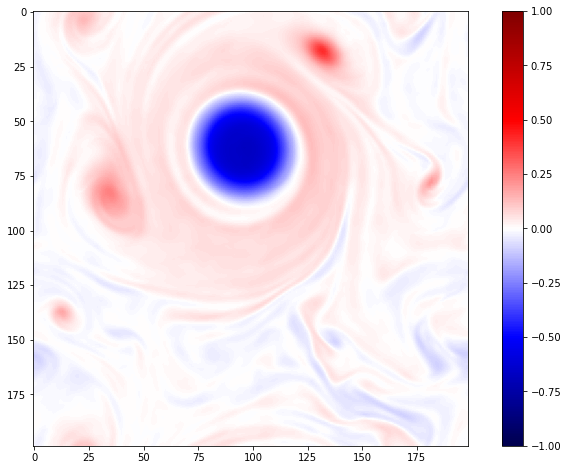

In [11]:
t=210
plt.figure(0, figsize=(12,8))
#plt.subplot(121)
plt.imshow(Vort[t], vmin=-1, vmax=1, cmap=cm.seismic) ; plt.colorbar()
#plt.subplot(122)
#plt.imshow(Vort_i[t], vmin=-1, vmax=1, cmap=cm.seismic) ; plt.colorbar()

### Strain 

In [11]:
dxUold=np.diff(U,axis=2)
dxUnew=np.zeros((Ns, Ny, Nx))
dxUnew[:,:,0]=dxUold[:,:,-1] ; dxUnew[:,:,-1]=dxUold[:,:,0] ; dxUnew[:,:,1:-1]=np.copy(dxUold)
dyVold=np.diff(V,axis=1)
dyVnew=np.zeros((Ns,Ny,Nx))
dyVnew[:,0,:]=dyVold[:,-1,:] ; dyVnew[:,-1,:]=dyVold[:,0,:] ; dyVnew[:,1:-1,:]=np.copy(dyVold)

Tens=dxUnew/dx - dyVnew/dy
TensR=(Tens[:,1:,1:]+Tens[:,:-1,1:]+Tens[:,1:,:-1]+Tens[:,:-1,:-1])/4
Shear=(np.diff(V,axis=2)/dx+np.diff(U,axis=1)/dy)

SLconst=0.17 # Smagorinsky-Lilly const
nuT=(SLconst**2*dx*dy)*np.sqrt(Shear**2+TensR**2)

In [9]:
### Intermediate depth field

dxUold_im=np.diff(U_im,axis=2)
dxUnew_im=np.zeros((Ns, Ny, Nx))
dxUnew_im[:,:,0]=dxUold_im[:,:,-1] ; dxUnew_im[:,:,-1]=dxUold_im[:,:,0] ; dxUnew_im[:,:,1:-1]=np.copy(dxUold_im)
dyVold_im=np.diff(V_im,axis=1)
dyVnew_im=np.zeros((Ns,Ny,Nx))
dyVnew_im[:,0,:]=dyVold_im[:,-1,:] ; dyVnew_im[:,-1,:]=dyVold_im[:,0,:] ; dyVnew_im[:,1:-1,:]=np.copy(dyVold_im)

Tens_im=dxUnew_im/dx - dyVnew_im/dy
TensR_im=(Tens_im[:,1:,1:]+Tens_im[:,:-1,1:]+Tens_im[:,1:,:-1]+Tens_im[:,:-1,:-1])/4

SLconst=0.17 # Smagorinsky-Lilly const
nuT_im=(SLconst**2*dx*dy)*np.sqrt((np.diff(V_im,axis=2)/dx+np.diff(U_im,axis=1)/dy)**2+TensR_im**2)

### Computing full vertical dynamical fields

In [11]:
Vort_f = (np.diff(V_f,axis=3)/dx-np.diff(U_f,axis=2)/dy)/f_coriolis

In [8]:
dxUold_f=np.diff(U_f,axis=3)
dxUnew_f=np.zeros((Ns, Nvert, Ny, Nx))
dxUnew_f[:,:,:,0]=dxUold_f[:,:,:,-1] ; dxUnew_f[:,:,:,-1]=dxUold_f[:,:,:,0] ; dxUnew_f[:,:,:,1:-1]=np.copy(dxUold_f)
dyVold_f=np.diff(V_f,axis=2)
dyVnew_f=np.zeros((Ns,Nvert,Ny,Nx))
dyVnew_f[:,:,0,:]=dyVold_f[:,:,-1,:] ; dyVnew_f[:,:,-1,:]=dyVold_f[:,:,0,:] ; dyVnew_f[:,:,1:-1,:]=np.copy(dyVold_f)

Tens_f=dxUnew_f/dx - dyVnew_f/dy
TensR_f=(Tens_f[:,:,1:,1:]+Tens_f[:,:,:-1,1:]+Tens_f[:,:,1:,:-1]+Tens_f[:,:,:-1,:-1])/4

SLconst=0.17 # Smagorinsky-Lilly const
nuT_f=(SLconst**2*dx*dy)*np.sqrt((np.diff(V_f,axis=3)/dx+np.diff(U_f,axis=2)/dy)**2+TensR_f**2)

In [16]:
np.percentile(nuT,90), np.percentile(nuT,10)

(0.7776635504795708, 0.06318878080213845)

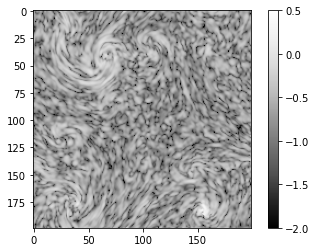

In [9]:
plt.imshow(np.log10(nuT_f[140,-25]), cmap=cm.Greys_r, vmin=-2,vmax=0.5) ; plt.colorbar()

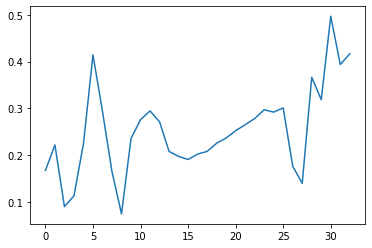

In [10]:
plt.plot(nuT_f[100,:,100,100])
#plt.yscale('log')

## Loading AMEDA result (with HDF5 refs)

In [12]:
## Param_eddy_tracking
params_dict = sio.loadmat(path_ameda+'param_eddy_tracking.mat')
deg=int(params_dict['deg']) ; resol=int(params_dict['resol'])

## Grid
grid_dict = sio.loadmat(path_ameda+'gridvel_deg'+str(deg)+'_resol'+str(resol)+'.mat')
x_am=grid_dict['x'] ; y_am=grid_dict['y']
## Tracks
D = h5py.File(path_ameda+'eddy_tracks.mat','r')  ## Or tracks2.mat ??
tracks=D['tracks']
Ned=tracks['step'].shape[0]
## Syntax : 
#D[D[tracks['shapes1'][Eddy_nb,0]][0][Timestep]][Streamline, X/Y]

print('Number of timesteps :'+str(int(params_dict['stepF'])) ) ## Checking time and shape
print('Number of eddies :'+str(Ned))

Number of timesteps :388
Number of eddies :1060


In [13]:
#StepEddy=np.zeros((Ned, len(time)))  ## Presence matrix
StepEddy=np.zeros((Ned, len(time_h)+1))  ## Presence matrix
Polarity=np.zeros(Ned)
for i in range(Ned):
    StepEddy[i,D[tracks['step'][i,0]][0].astype(int)-1]=1  
    ### "-1" is important because steps are counted in Matlab, in Python first index starts at 0
    Polarity[i]=np.mean(D[tracks['type'][i,0]][0].astype(int))
Color=np.zeros(Ned).astype(str)
Color[Polarity==-1]='b' ; Color[Polarity==1]='r'

Text(0.5, 1.0, 'Eddy occurence matrix')

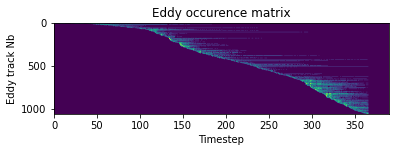

In [14]:
plt.imshow(StepEddy, aspect=1/10) ; plt.xlabel('Timestep') ; plt.ylabel('Eddy track Nb')
plt.title('Eddy occurence matrix')
## np.where(StepEddy[0,:]) #: to have index of first appearance

In [15]:
MainEddy=np.where((np.sum(StepEddy, axis=1)>180) & (Polarity==1))[0]
print( 'Eddy index living more than x timesteps :')
[ x for x in MainEddy.astype(str)]

#### MANUAL SELECTION

#MainEddy=np.array([0,44]) ### QWA115
#DayEddy=np.array([[0,420],[422,720]])

#MainEddy=np.array([4]) ### QWA121-2

#MainEddy=np.array([0,168,383]) ### QWA120
#DayEddy=np.array([[0,240],[242,610],[612,720]])

#MainEddy=np.array([15,0]) ### QWA119-3
#DayEddy=np.array([[190,240],[242,380]])

#MainEddy=np.array([0,158]) ### QWA119-3
#DayEddy=np.array([[0,430],[432,720]])

MainEddy=np.array([0,158]) ### QWA204
DayEddy=np.array([[0,440],[442,720]])

Eddy index living more than x timesteps :


['0']

### New manual tracking

Text(0, 0.5, 'Days')

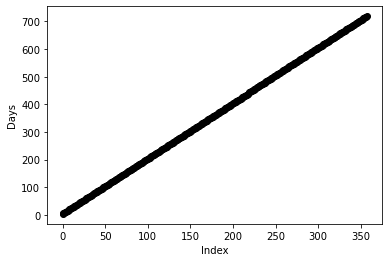

In [50]:
Rmax=[] ; Vmax=[] ; timeeddy=[] ; X1=[] ; Y1=[]
for ide,h in enumerate(MainEddy):
#h=167; ide=1
    steps=D[tracks['step'][h,0]][0]*timestep+time_h[0]  ## Adding time_h[0] in case of restart\
    ided=np.where((steps>=DayEddy[ide][0]) & (steps<=DayEddy[ide][1]))[0]

    Rmax+=list(D[tracks['rmax1'][h,0]][0][ided])
    Vmax+=list(D[tracks['velmax1'][h,0]][0][ided])
    timeeddy+=list(D[tracks['step'][h,0]][0][ided]*timestep+time_h[0])
    X1+=list(D[tracks['x1'][h,0]][0][ided]) ; Y1+=list(D[tracks['y1'][h,0]][0][ided])
plt.plot(timeeddy,'ok') ; timeeddy=np.array(timeeddy).astype(int)
plt.xlabel('Index') ; plt.ylabel('Days')

### Old version

Text(0, 0.5, 'Days')

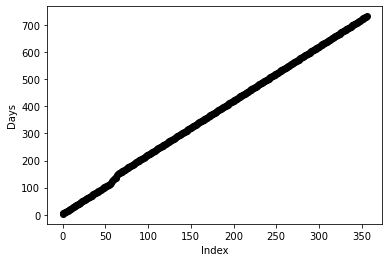

In [16]:
Rmax=[] ; Vmax=[] ; timeeddy=[] ; X1=[] ; Y1=[]
for h in MainEddy:  ## MainEddy should contain only the eddy to be tracked !!
    Rmax+=list(D[tracks['rmax1'][h,0]][0])
    Vmax+=list(D[tracks['velmax1'][h,0]][0])
    timeeddy+=list(D[tracks['step'][h,0]][0]*timestep+time_h[0])
    X1+=list(D[tracks['x1'][h,0]][0]) ; Y1+=list(D[tracks['y1'][h,0]][0])
plt.plot(timeeddy,'ok') ; timeeddy=np.array(timeeddy).astype(int)
plt.xlabel('Index') ; plt.ylabel('Days')

###  SST Scaling

In [19]:
SSTmax=np.max(temp[:,-1],axis=(1,2))   ### AVG version
SSTmin=np.min(temp[:,-1],axis=(1,2))
SSTmean=np.mean(temp[:,-1],axis=(1,2))

NameError: name 'temp' is not defined

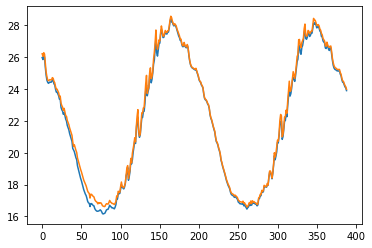

In [17]:
SSTmax_h=np.max(temp_h[:,-1],axis=(1,2))   ### HIS version
SSTmin_h=np.min(temp_h[:,-1],axis=(1,2))
SSTmean_h=np.mean(temp_h[:,-1],axis=(1,2)) #nd.gaussian_filter1d(np.mean(temp_h[:,-1],axis=(1,2)),sigma=2)
plt.plot(SSTmin_h) ; plt.plot(SSTmean_h)

In [18]:
cust=cm.Spectral_r ; Ncycl=0
my_cmap = cust(np.arange(cust.N))
my_cmap[:,-1] = 1-0.9*(np.sin(np.linspace(0, Ncycl*np.pi, cust.N))**10) #np.linspace(0, 1, cust.N)
my_cmap = col.ListedColormap(my_cmap)

## SST map alone with AMEDA

100%|██████████| 30/30 [00:01<00:00, 25.99it/s]


Text(0.5, 0.95, 'Run QWC5 - Cyclone 1km ERA5 1-hour  - t= 241 days')

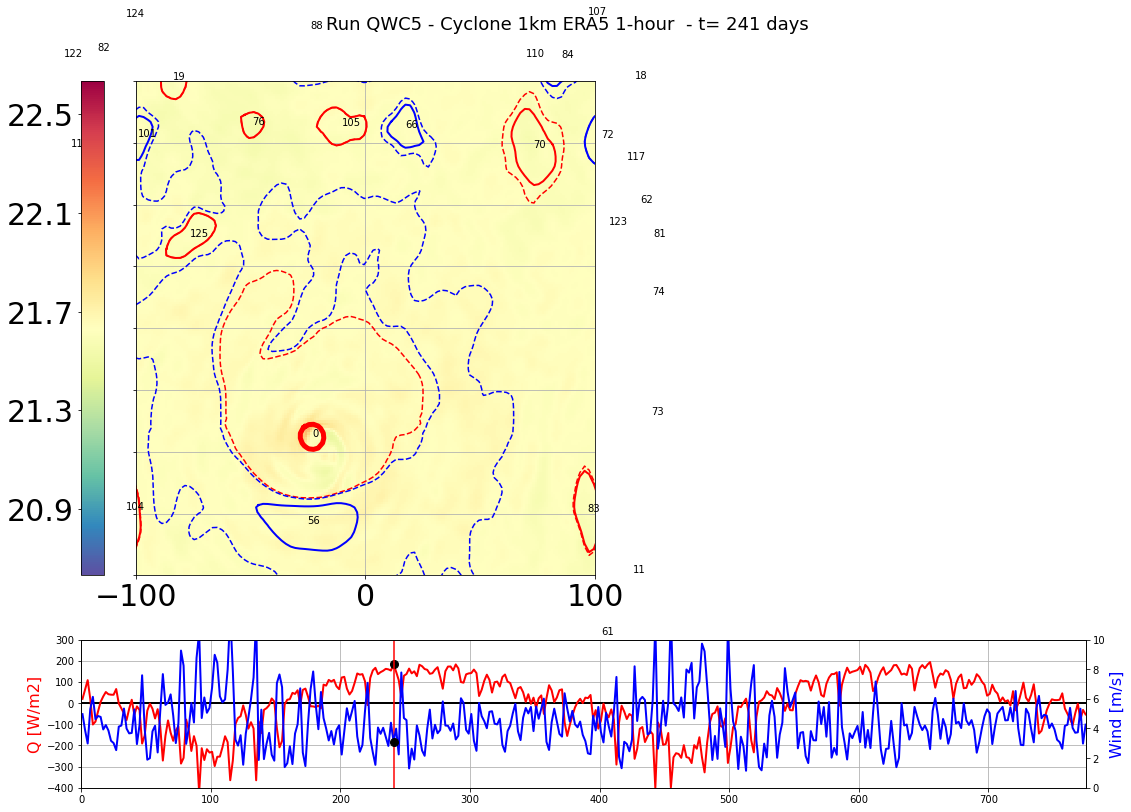

In [21]:
t=120 ; plot_number=True ; dTmax=1
SSTticks=np.arange(SSTmean_h[t]-2.5-(SSTmean_h[t]-dTmax)%1, SSTmean_h[t]+2-(SSTmean_h[t]-dTmax)%1,0.4)

plt.figure(0, figsize=(18,13))
gs = GridSpec(2, 3, width_ratios=[1/20,1,1], height_ratios=[10,3], wspace=0.1, hspace=0.2)

### SST
plt.subplot(gs[0,1])
plt.pcolormesh(xi_rho,xi_rho,temp_h[t,-1,:,:],vmin=SSTmean_h[t]-dTmax, vmax=SSTmean_h[t]+dTmax,cmap=cm.Spectral_r)

### Plotting AMEDA eddies
ListPs=np.where(StepEddy[:,t])[0]
for i in tqdm(range(len(ListPs))):
    if ListPs[i] in MainEddy:
        lw=5  ## THicker line for Main Eddy
    else:
        lw=2
    idt=np.where(D[tracks['step'][ListPs[i],0]][0]-1==t)[0]
    ### Plotting Rmax
    Contour=D[D[tracks['shapes1'][ListPs[i],0]][0][int(idt)]][:]
    plt.plot(Contour[:,0], Contour[:,1], '-', lw=lw, color=Color[ListPs[i]])
    if plot_number:
        plt.text(np.mean(Contour[:,0]), np.mean(Contour[:,1]), str(ListPs[i]))
    
    ### Plotting Rend
    Contour=D[D[tracks['shapes3'][ListPs[i],0]][0][int(idt)]][:]
    plt.plot(Contour[:,0], Contour[:,1], '--', color=Color[ListPs[i]])

#plt.title('SST', size=19)  
#plt.plot([0,0],[0,0],'-r', label='Cyclone') ; plt.plot([0,0],[0,0],'-b', label='Anticyclone')
plt.xlim([-Xmax,Xmax]) ; plt.ylim([-Xmax,Xmax]) ; plt.grid() #; plt.ylabel('Distance [km]', size=18)
plt.xticks(np.arange(-100,110,100))
plt.tick_params(labelleft=False, labelsize=30)
CB1=plt.colorbar(cax=plt.subplot(gs[0,0]))#, orientation='horizontal')
CB1.ax.set_xlim([SSTmean_h[t]-dTmax,SSTmean_h[t]+dTmax])
CB1.set_ticks(list(SSTticks),[ '%0.2f'%x for x in SSTticks ])
CB1.ax.tick_params(left=True, right=False, labelright=False, labelleft=True, labelsize=30)

#plt.subplot(gs[0,2])  ### Vorticity
#plt.pcolor(x_psi, y_psi, Vort[t,:], cmap=cm.seismic, vmin=-1, vmax=1)
#plt.title('Vorticity at 15m', size=19)
#plt.xlim([-Xmax,Xmax]) ; plt.ylim([-Xmax,Xmax]) ; plt.grid()
#CB2=plt.colorbar(cax=plt.subplot(gs[1,1]), orientation='horizontal')
#CB2.ax.set_xlabel('Vorticity/f', fontsize=15)

ax1=plt.subplot(gs[1,:])    ### Q 
plt.plot([0,time[-1]],[0,0],'-k',lw=2)
plt.plot(time, Qmean,'-r', lw=2) ; plt.grid()
tf=np.argmin(np.abs(time-time[t]))
plt.plot(time[tf], Qmean[tf],'ok', ms=8)
plt.plot([time[tf]]*2, [-500,400],'-r')
plt.ylabel('Q [W/m2]',size=16, color='r')
plt.ylim([-400,300])

ax2=ax1.twinx()      ### Wind
ax2.plot(time, Wspeed,'-b',lw=2)
plt.plot(time[tf], Wspeed[tf],'ok', ms=8)
plt.ylabel('Wind [m/s]',size=16, color='b')
plt.xlim([0,time[-1]]) ; plt.ylim([0,10])

plt.suptitle(str_title+' - t= '+str(int(time[t]))+' days', size=18, y=0.95)


## Computing Eddy Mask

In [16]:
np.shape(x_rho)

(200, 200)

In [17]:
xlist=np.reshape(x_rho,len(x_rho)**2) ; ylist=np.reshape(y_rho,len(x_rho)**2)
#xpsilist=np.reshape(x_psi,len(x_psi)**2) ; ypsilist=np.reshape(y_psi,len(x_psi)**2)
pts=np.array([xlist,ylist]).T #; ptspsi=np.array([xpsilist,ypsilist]).T
MaskEnd=np.zeros((Ns, Nx,Nx))      ### mask in time_avg !
for t in tqdm(range(len(time))):
    ListPs=np.where(StepEddy[:,t])[0]
    ### Mask removing all eddies
    for i in range(len(ListPs)):
        idt=np.where(D[tracks['step'][ListPs[i],0]][0]-1==t)[0]## Rmax or Rend : 'shapes1' or 'shapes3'
        Contour=D[D[tracks['shapes3'][ListPs[i],0]][0][int(idt)]][:]
        path=mpp.Path(Contour, closed=True)
        Inside=np.reshape(path.contains_points(pts), np.shape(x_rho)) ; MaskEnd[t]+=Inside  

MaskEnd=MaskEnd.astype(bool)

100%|██████████| 388/388 [00:43<00:00,  8.88it/s]


Text(0.5, 1.0, 'Masking all eddies')

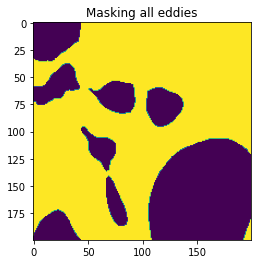

In [24]:
t=320  ## Check
plt.imshow(~MaskEnd[t]) ; plt.title('Masking all eddies')

In [32]:
MixOut_h=np.zeros((Nh,Nvert+1)) ; EpsOut_h=np.zeros((Nh,Nvert+1))
Nt=1   ## His time-stepping  =1 or =Navg
for t in tqdm(range(Nh-100)):
    tf=np.argmin(np.abs(time-time_h[t]))
    if np.any(MaskEnd[tf]):
        for k in range(Nt):  ### Data from HIS
            for z in range(Nvert+1):
                MixOut_h[t*Nt+k,z]=np.average(AKv[t*Nt+k,z], weights=MaskEnd[tf]) ## +1 because on s_w
                EpsOut_h[t*Nt+k,z]=np.average(Eps[t*Nt+k,z], weights=MaskEnd[tf])
    #else:
MixOut_h[MixOut_h==0]=np.nan ; EpsOut_h[EpsOut_h==0]=np.nan

100%|██████████| 344/344 [00:08<00:00, 38.31it/s]


In [37]:
Ak_anom=np.copy(AKv) ; Eps_anom=np.copy(Eps)
for t in tqdm(range(Nh-100)):
    Ak_anom[t]=AKv[t]/np.repeat(np.repeat(MixOut_h[t,:,np.newaxis],Nx, axis=1)[:,:,np.newaxis],Nx,axis=2)
    Eps_anom[t]=Eps[t]/np.repeat(np.repeat(EpsOut_h[t,:,np.newaxis],Nx, axis=1)[:,:,np.newaxis],Nx,axis=2)

100%|██████████| 344/344 [00:42<00:00,  8.10it/s]


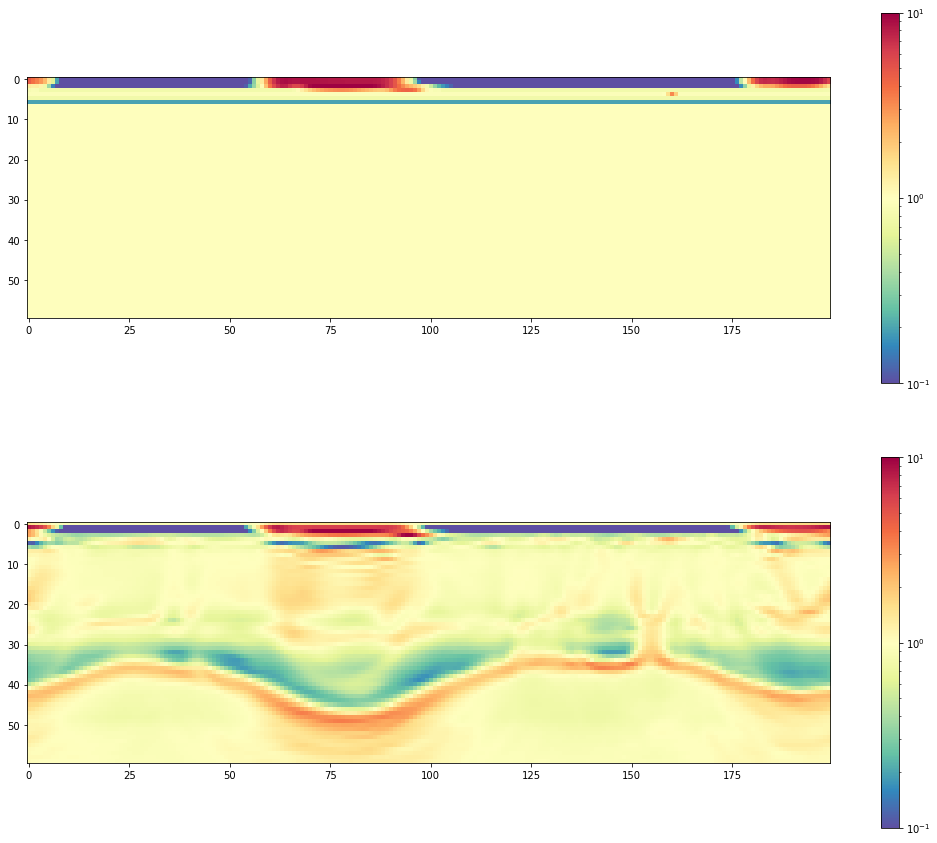

In [63]:
t=100
plt.figure(0, figsize=(18,15))
plt.subplot(211)
plt.imshow(Ak_anom[t,::-1,100], cmap=cm.Spectral_r, norm=col.LogNorm(vmin=1e-1, vmax=1e1)) ; plt.colorbar()
plt.subplot(212)
plt.imshow(Eps_anom[t,::-1,100], cmap=cm.Spectral_r, norm=col.LogNorm(vmin=1e-1, vmax=1e1)) ; plt.colorbar()

## SST & Vorticity & AKv maps with AMEDA

Text(0.5, 1.0, 'Max Eps')

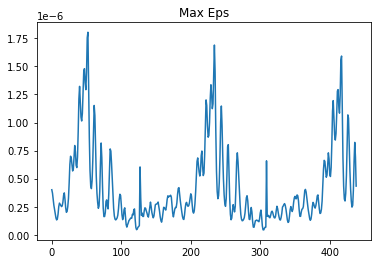

In [48]:
plt.plot(np.max(Eps[5:,idmax:],axis=(1,2,3)))
plt.title('Max Eps over vertical')

In [66]:
np.array(list(np.arange(25.5,27,0.3))+list(np.arange(27.1,29.2,0.1)))

array([25.5, 25.8, 26.1, 26.4, 26.7, 27.1, 27.2, 27.3, 27.4, 27.5, 27.6,
       27.7, 27.8, 27.9, 28. , 28.1, 28.2, 28.3, 28.4, 28.5, 28.6, 28.7,
       28.8, 28.9, 29. , 29.1])

Text(0.5, 0.9, 'Run QWA33 - ERA5 1-hour with SST retroaction - t= 251 days')

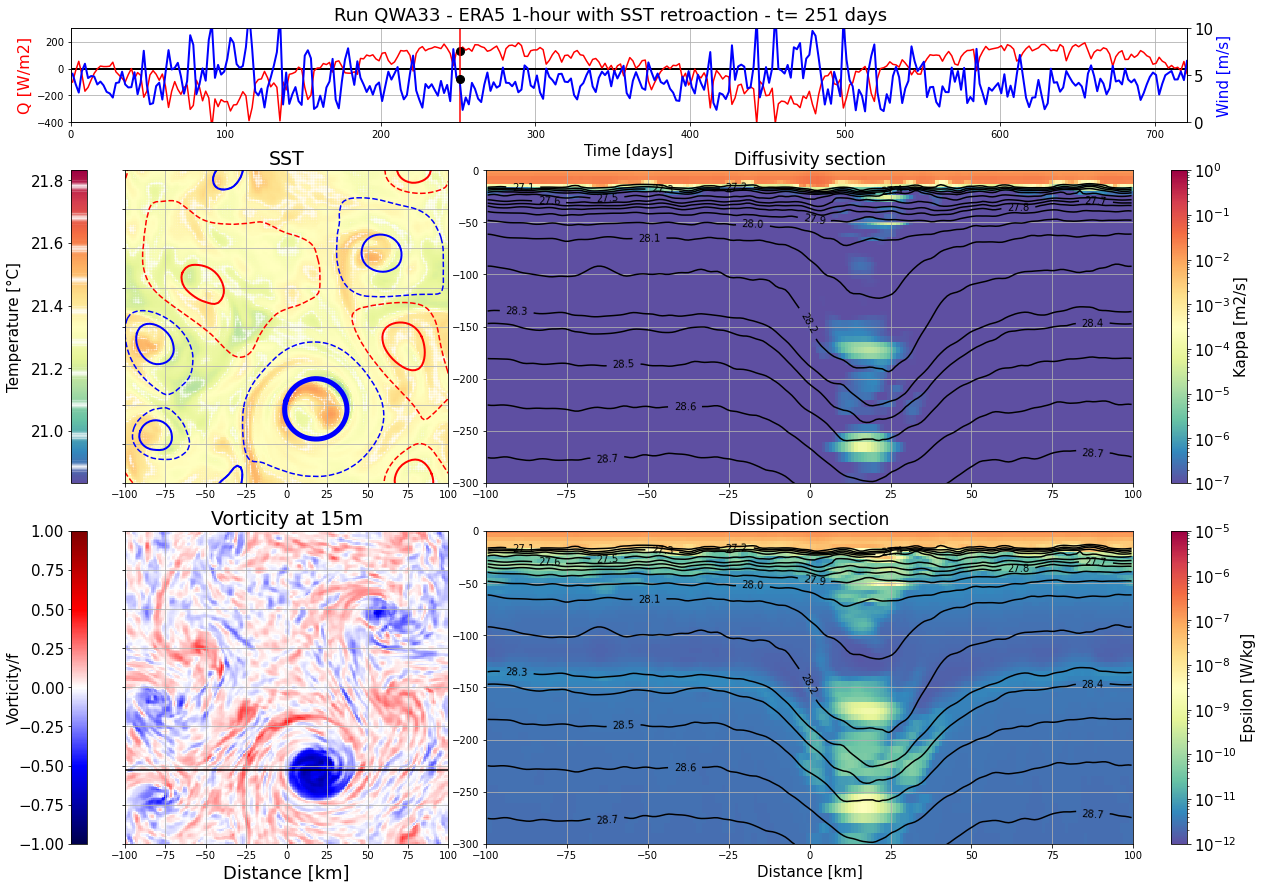

In [23]:
t=125
mode = 'plain' # 'plain' or 'anom'

T0=25 ; R0=26 ; Tcoef=0.28    ### Translating temperature to density
ided=np.where(timeeddy==t*timestep)[0]
if len(ided)>0:
    idy=np.argmin(np.abs(xi_rho-Y1[ided[0]]))
Sigma=R0-Tcoef*(temp_h[t,:,idy]-T0)
Levels=np.array(list(np.arange(25.5,27,0.3))+list(np.arange(27.1,29.2,0.1)))
SSTticks=np.arange(SSTmean_h[t]-1.5-(SSTmean_h[t]-0.5)%1, SSTmean_h[t]+1.5-(SSTmean_h[t]-0.5)%1,0.2)

plt.figure(0, figsize=(20,15))
gs = GridSpec(3, 4, width_ratios=[0.5,10,20,0.5], height_ratios=[3,10,10], wspace=0.15, hspace=0.2)

plt.subplot(gs[1,1])           ### SST
plt.pcolormesh(xi_rho,xi_rho,temp_h[t,-1,:,:],vmin=SSTmean_h[t]-0.5, vmax=SSTmean_h[t]+0.5,cmap=my_cmap)#cm.RdYlBu_r)#Spectral_r)
ListPs=np.where(StepEddy[:,t])[0]
for i in range(len(ListPs)):
    if ListPs[i] in MainEddy:
        lw=5  ## THicker line for Main Eddy
    else:
        lw=2
    idt=np.where(D[tracks['step'][ListPs[i],0]][0]-1==t)[0]
    Contour=D[D[tracks['shapes1'][ListPs[i],0]][0][int(idt)]][:]         ### Plotting Rmax
    plt.plot(Contour[:,0], Contour[:,1], '-', lw=lw, color=Color[ListPs[i]])
    Contour=D[D[tracks['shapes3'][ListPs[i],0]][0][int(idt)]][:]         ### Plotting Rend
    plt.plot(Contour[:,0], Contour[:,1], '--', color=Color[ListPs[i]])

plt.title('SST', size=19)  
plt.plot([0,0],[0,0],'-r', label='Cyclone') ; plt.plot([0,0],[0,0],'-b', label='Anticyclone') #; plt.legend(loc=2, fontsize=13)
plt.xlim([-Xmax,Xmax]) ; plt.ylim([-Xmax,Xmax]) ; plt.grid()# ; plt.xlabel('Distance [km]', size=18)
plt.tick_params(labelleft=False)
CB1=plt.colorbar(cax=plt.subplot(gs[1,0]))#, orientation='horizontal')
CB1.ax.set_ylabel(u'Temperature [\N{DEGREE SIGN}C]', fontsize=15, labelpad=-80)
CB1.ax.set_ylim([SSTmean_h[t]-0.5,SSTmean_h[t]+0.5])
CB1.set_ticks(list(SSTticks),[ '%0.2f'%x for x in SSTticks ])
CB1.ax.tick_params(left=True, right=False, labelright=False, labelleft=True, labelsize=15)

plt.subplot(gs[2,1])                      ### Vorticity
plt.pcolor(x_psi, y_psi, Vort[t,:], cmap=cm.seismic, vmin=-1, vmax=1)
idy=np.argmin(np.abs(xi_rho-Y1[t]))  ; plt.plot([-Xmax,Xmax],[xi_rho[idy]]*2,'-k')
plt.title('Vorticity at 15m', size=19) ; plt.xlabel('Distance [km]', size=18)
plt.xlim([-Xmax,Xmax]) ; plt.ylim([-Xmax,Xmax]) ; plt.grid() ; plt.tick_params(labelleft=False)
CB2=plt.colorbar(cax=plt.subplot(gs[2,0]))#, orientation='horizontal')
CB2.ax.set_ylabel('Vorticity/f', fontsize=15, labelpad=-80)
CB2.ax.tick_params(left=True, right=False, labelright=False, labelleft=True, labelsize=15)


ax1 = plt.subplot(gs[0,:])                 ### Q 
plt.plot([0,time[-1]],[0,0],'-k',lw=2) ;plt.plot(time, Qmean,'-r') ; plt.grid() ; plt.xlabel('Time [days]',size=15)
tf=np.argmin(np.abs(time-time_h[t]))
plt.plot(time[tf], Qmean[tf],'ok', ms=8) ; plt.plot([time[tf]]*2, [-400,300],'-r')
plt.ylabel('Q [W/m2]',color='r', size=16) ;plt.xlim([0,time_h[-1]]) ; plt.ylim([-400,300])

ax2=ax1.twinx()                      ### Wind
ax2.plot(time, Wspeed,'-b',lw=2) ; plt.plot(time[tf], Wspeed[tf],'ok', ms=8)
plt.ylabel('Wind [m/s]',size=15, color='b')
plt.xlim([0,time_h[-1]]) ; plt.ylim([0,10]) ; plt.tick_params(labelsize=15)

plt.subplot(gs[1,2])                ### AKv
if mode=='plain':
    CP0=plt.pcolor(xi_rho, z_dzt, AKv[t,:,idy], cmap=cm.Spectral_r, norm=col.LogNorm(vmin=1e-7, vmax=1e-0))# vmin=1e-4, vmax=0.1)
if mode=='anom':
    CP0=plt.pcolor(xi_rho, z_dzt, Ak_anom[t,:,idy], cmap=cm.seismic, norm=col.LogNorm(vmin=3e-2, vmax=30))# vmin=1e-4, vmax=0.1)
CP2=plt.contour(xi_rho, zvert, Sigma, colors=['k'],levels=Levels)
plt.clabel(CP2, Levels, fmt='%3.1f')
plt.xlim([-Xmax,Xmax]) ; plt.ylim([-300,0]) ; plt.grid()
plt.title('Diffusivity section',size=17) #; plt.xlabel('Distance [km]',size=15)
CB2=plt.colorbar(CP0,cax=plt.subplot(gs[1,3]), orientation='vertical')
CB2.ax.set_ylabel('Kappa [m2/s]', fontsize=15)
CB2.ax.tick_params(labelsize=15)

plt.subplot(gs[2,2])                  ### Epsilon
if mode=='plain':
    CP1=plt.pcolor(xi_rho, z_dzt, Eps[t,:,idy], cmap=cm.Spectral_r, norm=col.LogNorm(vmin=1e-12, vmax=1e-5))# vmin=1e-4, vmax=0.1)
if mode=='anom':
    CP1=plt.pcolor(xi_rho, z_dzt, Eps_anom[t,:,idy], cmap=cm.seismic, norm=col.LogNorm(vmin=3e-2, vmax=30))# vmin=1e-4, vmax=0.1)
CP2=plt.contour(xi_rho, zvert, Sigma, colors=['k'],levels=Levels)
plt.clabel(CP2, Levels, fmt='%3.1f')
plt.xlim([-Xmax,Xmax]) ; plt.ylim([-300,0]) ; plt.grid()
plt.title('Dissipation section',size=17) ; 
plt.xlabel('Distance [km]',size=15)
CB2=plt.colorbar(CP1, cax=plt.subplot(gs[2,3]), orientation='vertical')
CB2.ax.set_ylabel('Epsilon [W/kg]', fontsize=15)
CB2.ax.tick_params(labelsize=15)

plt.suptitle(str_title+' - t= '+str(int(time[t]))+' days', size=18, y=0.90)

## Computing Mixed Layer Depth

In [29]:
MLDind=np.zeros((Ns, Nx,Nx))     ## AVG version
for t in tqdm(range(Ns)):
    DT=(np.abs(temp[t,:]-temp[t,-1])<mldthres)
    MLDind[t]=np.argmin(~DT,axis=0)

  0%|          | 0/388 [00:00<?, ?it/s]


NameError: name 'temp' is not defined

In [22]:
MLDind_h=np.zeros((Nh, Nx,Nx))   #### HIS version
for t in tqdm(range(Nh)):
    DT=(np.abs(temp_h[t,:]-temp_h[t,-1])<mldthres)
    MLDind_h[t]=np.argmin(~DT,axis=0)

100%|██████████| 389/389 [00:03<00:00, 103.70it/s]


<ipython-input-24-e410a0d69998>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  CB.ax.set_yticklabels(labels)


[Text(1, 10.0, '-181'),
 Text(1, 20.0, '-129'),
 Text(1, 30.0, '-87'),
 Text(1, 40.0, '-49'),
 Text(1, 50.0, '-12')]

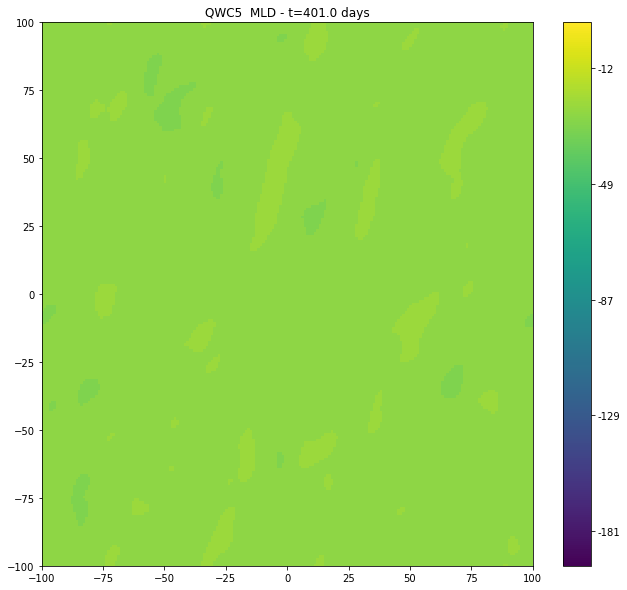

In [24]:
t=200  ### Check MLD
MLDmax=200
plt.figure(0,figsize=(11,10))
plt.pcolor(xi_rho, xi_rho,MLDind_h[t], vmin=np.argmin(np.abs(zvert+MLDmax)) , vmax=len(zvert))
CB=plt.colorbar() #; CB.ax.set_yticks(ticks) ; 
plt.title(str_title[4:9]+ ' MLD - t='+'%3.1f'%time[t]+' days')
ticks=CB.get_ticks()
f = interp.interp1d(np.arange(len(zvert)), zvert)
labels=['%3.0f'%(f(x)) for x in ticks]
CB.ax.set_yticklabels(labels)

#ticks = [ x for x,i in enumerate(zvert.astype(int))] ; labels=[str(x) for x in zvert.astype(int)]

## SST - Vort surf - Vorticity section

In [25]:


dz=np.repeat(np.diff(zvert)[:,np.newaxis],Nx,axis=1)
zs=(zvert[1:]+zvert[:-1])/2

Buoy= -9.81 * Sigma/1026

dxB=np.diff(Buoy,axis=1)/dx
dzB=np.diff(Buoy,axis=0)/dz
dzV=np.diff(V_f[t,:,idy],axis=0)
dxV=np.diff(V_f[t,:,idy],axis=1)

dxB_m=(dxB[1:]+dxB[:-1])/2 ; dzB_m=(dzB[:,1:]+dzB[:,:-1])/2 
dxV_m=(dxV[1:]+dxV[:-1])/2 ; dzV_m=(dzV[:,1:]+dzV[:,:-1])/2 

qpv=((f_coriolis + dxV_m)*dzB_m - dzV_m*dxB_m)/f_coriolis
#dzB_m=(dzB[:,1:]+dzB[:,:-1])/2
#Vort_f_m=(Vort_f[t,:-1,idy]+Vort_f[t,1:,idy])/2


#plt.imshow((f_coriolis+Vort_f_m)*dzB_m) ; plt.colorbar()
plt.imshow(qpv, vmin=-1, vmax=1, cmap=cm.seismic) ; plt.colorbar()

NameError: name 'Sigma' is not defined

In [33]:
np.shape(U_f[t,:,idy]), np.shape(Vort_f[t, :,idy])

((54, 199), (54, 199))

<ipython-input-51-0538b5c85b6a>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  CB.ax.set_xticklabels(labels)
100%|██████████| 11/11 [00:00<00:00, 267.40it/s]


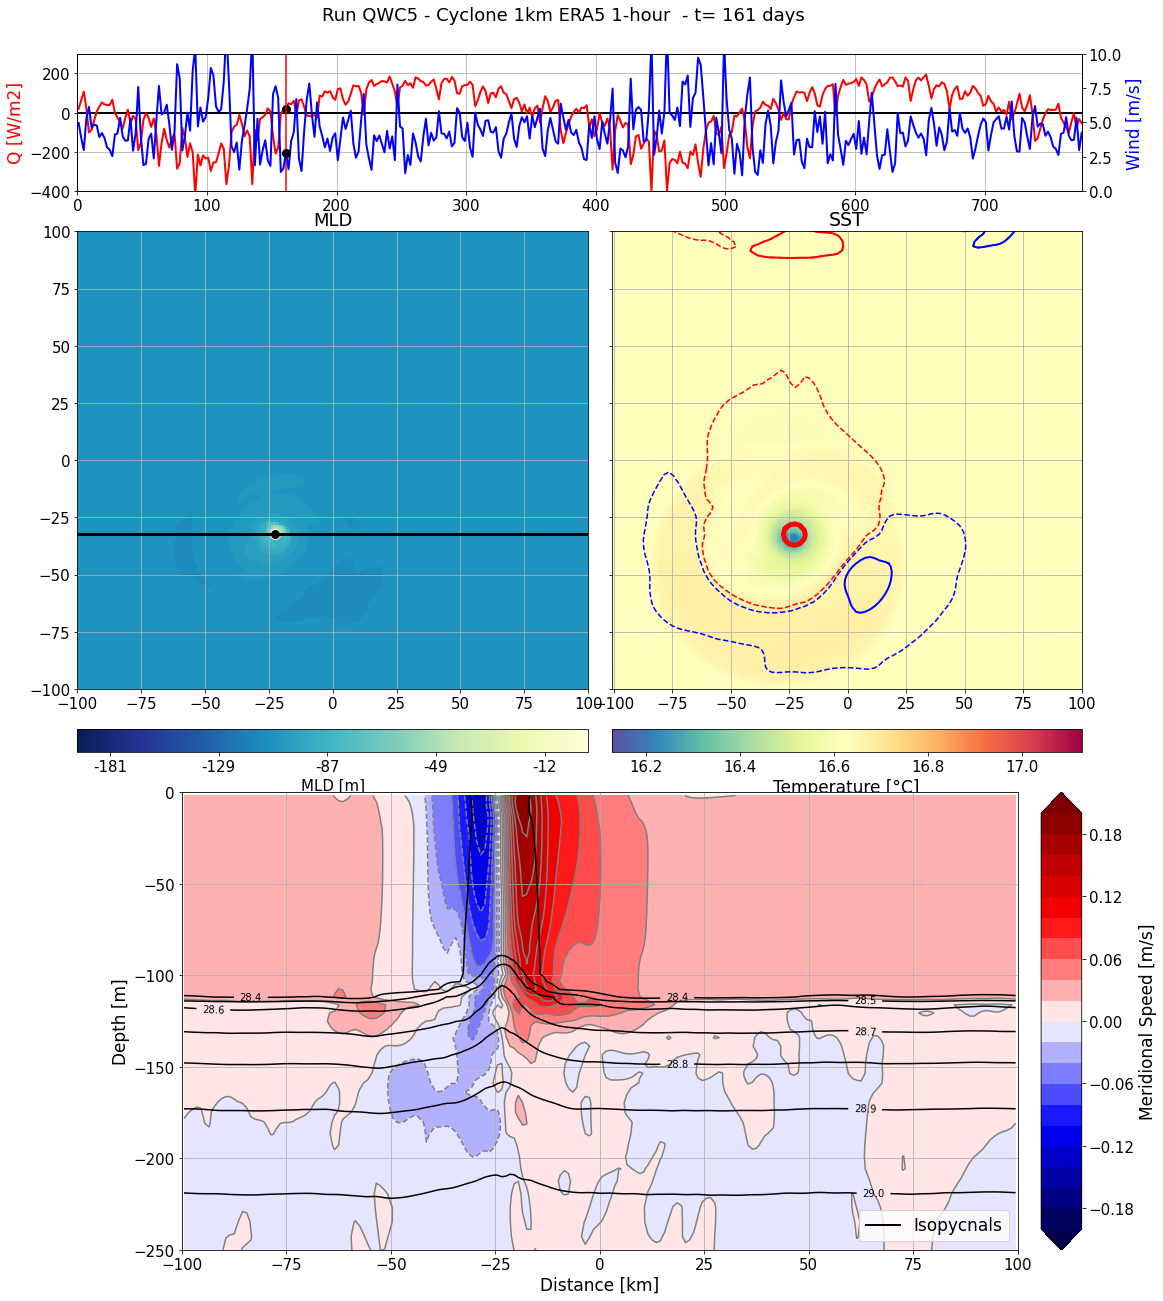

In [51]:
t=80 ; plot_number=False ; TS=15 ; LS=17 ; dTmax=0.5
T0=25 ; R0=26 ; Tcoef=0.28  
Levels=np.arange(25.5,29.2,0.1)
Levels_v=np.arange(-1,1.1,0.2)
 
IDY=np.zeros(Nh)    ### For .npy storage
SIGMA=np.zeros((Nh,Nvert,Nx))
Vort_sect=np.zeros((Nh,Nvert,Nx-1))
QPV=np.zeros((Nh,Nvert-1,Nx-1))

### Takes into consideration if "multiple Main" => takes the first one
ted=np.argmin(np.abs(timeeddy-time_h[t]))
idy=np.argmin(np.abs(xi_rho-Y1[ted]))

SSTticks=np.arange(SSTmean_h[t]-1.5-(SSTmean_h[t]-0.5)%1, SSTmean_h[t]+1.5-(SSTmean_h[t]-0.5)%1,0.2)
Sigma=R0-Tcoef*(temp_h[t,:,idy]-T0) ; Buoy= -9.81 * Sigma/1026

### Computing Ertel PV (Hoskins 1974)
#dxB=np.diff(Buoy,axis=1)/dx ; dzB=np.diff(Buoy,axis=0)/dz
#dzV=np.diff(V_f[t,:,idy],axis=0) ; dxV=np.diff(V_f[t,:,idy],axis=1)
#dxB_m=(dxB[1:]+dxB[:-1])/2 ; dzB_m=(dzB[:,1:]+dzB[:,:-1])/2 ; dxV_m=(dxV[1:]+dxV[:-1])/2 ; dzV_m=(dzV[:,1:]+dzV[:,:-1])/2 
#qpv=((f_coriolis + dxV_m)*dzB_m - dzV_m*dxB_m)/f_coriolis

#### Figure 
plt.figure(0, figsize=(18,22))
gs = GridSpec(4, 4, width_ratios=[2,10,10,1], height_ratios=[3,10,0.5,10], wspace=0.1, hspace=0.15)

plt.subplot(gs[1,:2])  ### MLD
CP=plt.pcolor(xi_rho, xi_rho,MLDind_h[t], vmin=np.argmin(np.abs(zvert+MLDmax)) , vmax=len(zvert), cmap=cm.YlGnBu_r)
plt.plot(X1[ted],Y1[ted],'ok',mec='w',ms=10)
plt.plot([-Xmax,Xmax],[xi_rho[idy]]*2,'-k',lw=3)
plt.title('MLD',size=18); plt.grid()# ;plt.ylabel('Distance [km]',size=15)  
plt.tick_params(labelsize=TS)
CB=plt.colorbar(CP,cax=plt.subplot(gs[2,:2]), orientation='horizontal') ; 
CB.ax.tick_params(labelsize=15) ; CB.set_label('MLD [m]',size=15)
ticks=CB.get_ticks()
labels=['%3.0f'%(f(x)) for x in ticks]
CB.ax.set_xticklabels(labels)

plt.subplot(gs[1,2:])  ### SST
plt.pcolor(xi_rho,xi_rho,temp_h[t,-1,:,:],vmin=SSTmean_h[t]-dTmax, vmax=SSTmean_h[t]+dTmax,cmap=my_cmap)#cm.RdYlBu_r)#Spectral_r)
ListPs=np.where(StepEddy[:,t])[0] ### Plotting AMEDA eddies
for i in tqdm(range(len(ListPs))):
    if ListPs[i] in MainEddy:
        lw=5  ## THicker line for Main Eddy
    else:
        lw=2
    idt=np.where(D[tracks['step'][ListPs[i],0]][0]-1==t)[0]
    Contour=D[D[tracks['shapes1'][ListPs[i],0]][0][int(idt)]][:]  ### Plotting Rmax
    plt.plot(Contour[:,0], Contour[:,1], '-', lw=lw, color=Color[ListPs[i]])
    Contour=D[D[tracks['shapes3'][ListPs[i],0]][0][int(idt)]][:]  ### Plotting Rend
    plt.plot(Contour[:,0], Contour[:,1], '--', color=Color[ListPs[i]])
plt.xlim([-Xmax-1,Xmax]) ; plt.ylim([-Xmax,Xmax]) ; plt.grid()
plt.tick_params(labelleft=False,labelsize=TS)
plt.title('SST', size=19)
CB1=plt.colorbar(cax=plt.subplot(gs[2,2:]), orientation='horizontal')
CB1.ax.set_xlabel(u'Temperature [\N{DEGREE SIGN}C]', fontsize=LS)
CB1.ax.set_xlim([SSTmean_h[t]-dTmax,SSTmean_h[t]+dTmax])
CB1.set_ticks(list(SSTticks),[ '%0.2f'%x for x in SSTticks ])
CB1.ax.tick_params(labelsize=TS)

ax1=plt.subplot(gs[0,:])    ### Q 
plt.plot([0,time[-1]],[0,0],'-k',lw=2)
plt.plot(time, Qmean,'-r', lw=2) ; plt.grid()
tf=np.argmin(np.abs(time-time_h[t]))
plt.plot(time[tf], Qmean[tf],'ok', ms=8)
plt.plot([time[tf]]*2, [-500,400],'-r')
plt.ylabel('Q [W/m2]',size=LS, color='r')
plt.ylim([-400,300]) ; plt.tick_params(labelsize=TS)

ax2=ax1.twinx()      ### Wind
ax2.plot(time, Wspeed,'-b',lw=2)
plt.plot(time[tf], Wspeed[tf],'ok', ms=8)
plt.ylabel('Wind [m/s]',size=LS, color='b')
plt.xlim([0,time[-1]]) ; plt.ylim([0,10])
plt.tick_params(labelsize=TS)

#plt.subplot(gs[3,1:3])  ### Vorticity Section
#CP3=plt.pcolor(xi_psi, zvert, Vort_f[t,:,idy], cmap=cm.seismic, vmin=Levels_v[0], vmax=Levels_v[-1])
#CP2=plt.contour(xi_rho, zvert, Sigma, colors=['k'],levels=Levels)
#plt.clabel(CP2, Levels, fmt='%3.1f')
#plt.tick_params(labelsize=TS, labelbottom=False)
#plt.xlim([-Xmax,Xmax]) ; plt.ylim([-300,0]) ; plt.grid()
#plt.ylabel('Depth [m]',size=LS) #; plt.xlabel('Distance [km]',size=LS)
#plt.plot([0,0],[0,0],'-k',lw=2, label='Isopycnals') ; plt.legend(loc=4,fontsize=LS)
#CB2=plt.colorbar(CP3, cax=plt.subplot(gs[3,3]), orientation='vertical')
#CB2.ax.set_ylabel('Vorticity/f', fontsize=LS) ; CB2.ax.tick_params(labelsize=TS)

plt.subplot(gs[3,1:3])  ### PV Section
#CP3=plt.pcolor(xi_psi, zs, qpv, cmap=cm.seismic, vmin=Levels_v[0]/10, vmax=Levels_v[-1]/10)
CP3=plt.contourf(xi_rho, zvert, V_f[t,:,idy],np.arange(-0.2,0.21,0.02), cmap=cm.seismic,extend='both')
CP4=plt.contour(xi_rho, zvert, V_f[t,:,idy],21,  colors=['gray'], vmin=-0.2, vmax=0.2)
CP2=plt.contour(xi_rho, zvert, Sigma, colors=['k'],levels=Levels)
plt.clabel(CP2, Levels, fmt='%3.1f')
plt.tick_params(labelsize=TS)
plt.xlim([-Xmax,Xmax]) ; plt.ylim([-250,0]) ; plt.grid()
plt.ylabel('Depth [m]',size=LS) ; plt.xlabel('Distance [km]',size=LS)
plt.plot([0,0],[0,0],'-k',lw=2, label='Isopycnals') ; plt.legend(loc=4,fontsize=LS)
CB2=plt.colorbar(CP3, cax=plt.subplot(gs[3,3]), orientation='vertical')
CB2.ax.set_ylabel('Meridional Speed [m/s]', fontsize=LS) ; CB2.ax.tick_params(labelsize=TS)

plt.suptitle(str_title+' - t= '+str(int(time[t]))+' days', size=18, y=0.91)

### Saving in .npy
IDY[t]=idy
SIGMA[t]=Sigma
Vort_sect[t]=Vort_f[t,:,idy]
QPV[t]=qpv


## Subplot for density - vorticity - nu turbulent

In [ ]:
t=148
### Takes into consideration if "multiple Main" => takes the first one
idt=np.where(timeeddy==t*timestep)[0]
if len(idt)>0:
    idy=np.argmin(np.abs(xi_rho-Y1[idt[0]]))

SSTticks=np.arange(SSTmean[t]-1.5-(SSTmean[t]-0.5)%1, SSTmean[t]+1.5-(SSTmean[t]-0.5)%1,0.2)
### Translating temperature to density
T0=25 ; R0=26 ; Tcoef=0.28  
Sigma=R0-Tcoef*(temp[t,:,idy]-T0)

Levels=np.arange(25.5,29.2,0.1)
Levels_v=np.arange(-1,1.1,0.2)

plt.figure(0, figsize=(18,24))
gs = GridSpec(4, 3, height_ratios=[5,12,10,10], width_ratios=[3,10,1], wspace=0.2, hspace=0.1)

plt.subplot(gs[0,:])    ### Q 
plt.plot([0,time[-1]],[0,0],'-k',lw=2)
plt.plot(dayflux, Qmean,'-r') ; plt.grid()
tf=np.argmin(np.abs(dayflux-time[t]))
plt.plot(dayflux[tf], Qmean[tf],'ok', ms=8)
plt.plot([dayflux[tf]]*2, [-400,300],'-r')
plt.ylabel('Q [W/m2]',size=17) ; plt.text(0,-600,'Time [days]',size=17); plt.tick_params(labelsize=15)
plt.xlim([0,time[-1]]) ; plt.ylim([-400,300])

plt.subplot(gs[1,1])  ### SST
CP1=plt.pcolor(xi_rho,xi_rho,temp[t,-1,:,:],vmin=SSTmean[t]-0.5, vmax=SSTmean[t]+0.5,cmap=my_cmap)#cm.RdYlBu_r)#Spectral_r)
plt.plot([-Xmax,Xmax],[xi_rho[idy]]*2,'-k')

### Plotting AMEDA eddies
ListPs=np.where(StepEddy[:,t])[0]
for i in tqdm(range(len(ListPs))):
    if ListPs[i] in MainEddy:
        lw=5  ## THicker line for Main Eddy
    else:
        lw=2
    idt=np.where(D[tracks['step'][ListPs[i],0]][0]-1==t)[0]
    ### Plotting Rmax
    Contour=D[D[tracks['shapes1'][ListPs[i],0]][0][int(idt)]][:]
    plt.plot(Contour[:,0], Contour[:,1], '-', lw=lw, color=Color[ListPs[i]])
    ### Plotting Rend
    Contour=D[D[tracks['shapes3'][ListPs[i],0]][0][int(idt)]][:]
    plt.plot(Contour[:,0], Contour[:,1], '--', color=Color[ListPs[i]])
plt.xlim([-Xmax,Xmax]) ; plt.ylim([-Xmax,Xmax]) ; plt.grid() ; plt.ylabel('Distance [km]',size=17)
plt.tick_params(labelsize=15)
CB1=plt.colorbar()#cax=plt.subplot(gs[1,2]), orientation='vertical')
CB1.ax.set_ylabel(u'SST [\N{DEGREE SIGN}C]', fontsize=17)
CB1.ax.set_xlim([SSTmean[t]-0.5,SSTmean[t]+0.5])
CB1.set_ticks(list(SSTticks),[ '%0.2f'%x for x in SSTticks ])
CB1.ax.tick_params(labelsize=15)

plt.subplot(gs[2,:2])  ### Vorticity
CP3=plt.pcolor(xi_psi, zvert, Vort_f[t,:,idy], cmap=cm.seismic, vmin=Levels_v[0], vmax=Levels_v[-1])
#CP4=plt.contour(xi_psi, zvert, Vort_f[t,:,idy], colors=['k'],levels=Levels_v)
#plt.clabel(CP4, Levels_v, fmt='%3.1f')
plt.plot([0,0],[0,0],'-k',lw=2, label='Isopycnals') ; plt.legend(loc=4,fontsize=17)
CP2=plt.contour(xi_rho, zvert, Sigma, colors=['k'],levels=Levels)
plt.clabel(CP2, Levels, fmt='%3.1f')
plt.xlim([-Xmax,Xmax]) ; plt.ylim([-depth_m,0]) ; plt.grid()
plt.ylabel('Depth [m]',size=17) ; plt.tick_params(labelsize=15)
CB3=plt.colorbar(CP3, cax=plt.subplot(gs[2,2]))
CB3.ax.set_ylabel('Vorticity /f', fontsize=17)
CB3.ax.tick_params(labelsize=15)


plt.subplot(gs[3,:2])  ### Nu Turbu
CP4=plt.pcolor(xi_psi, zvert, nuT_f[t,:,idy], cmap=cm.Spectral_r, norm=col.LogNorm(vmin=1e-2, vmax=5))
plt.xlim([-Xmax,Xmax]) ; plt.ylim([-depth_m,0]) ; plt.grid()
plt.ylabel('Depth [m]',size=17) ; plt.xlabel('Distance [km]',size=17)
plt.tick_params(labelsize=15)
CB4=plt.colorbar(cax=plt.subplot(gs[3,2]))
CB4.ax.set_ylabel('nu Turb [m2/s]', fontsize=17)
CB4.ax.tick_params(labelsize=15)

plt.suptitle(str_title+' - t= '+str(int(time[t]))+' days', size=18, y=0.91)

## SST & MLD maps with AMEDA

In [56]:
ticks
labels=['%3.0f'%(f(x)) for x in ticks]
labels

['-181', '-129', '-87', '-49', '-12']

100%|██████████| 11/11 [00:00<00:00, 100.46it/s]
<ipython-input-58-84865852c363>:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  CB.ax.set_xticklabels(labels)


Text(0.5, 0.95, 'Run QWA204 - CFB 1km ERA5 weekly  - t= 301.0 days')

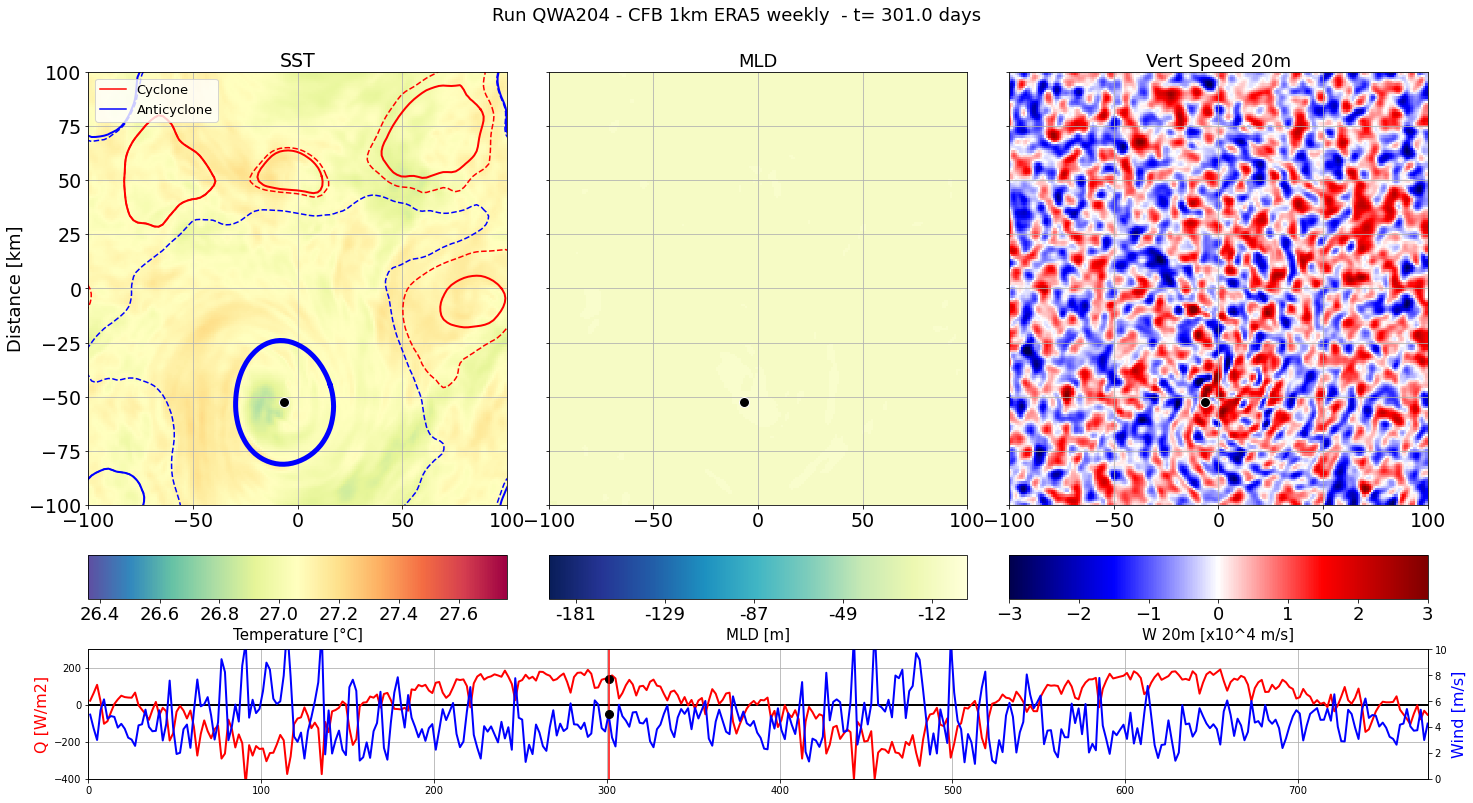

In [58]:
t=150
plot_number=False ; MLDmax=200 ; dTmax=0.7 ; TS=19
f = interp.interp1d(np.arange(len(zvert)), zvert)
SSTticks=np.arange(SSTmean_h[t]-2.5-(SSTmean_h[t]-dTmax)%1, SSTmean_h[t]+2.5-(SSTmean_h[t]-dTmax)%1,0.2)

plt.figure(0, figsize=(24,13))
gs = GridSpec(3, 3, width_ratios=[1,1,1], height_ratios=[10,1,3], wspace=0.1, hspace=0.25)

### SST
plt.subplot(gs[0,0])
plt.pcolormesh(xi_rho,xi_rho,temp_h[t,-1,:,:],vmin=SSTmean_h[t]-dTmax, vmax=SSTmean_h[t]+dTmax,cmap=cm.Spectral_r)#cm.RdYlBu_r)#Spectral_r)

### Plotting AMEDA eddies
tf=np.argmin(np.abs(time-time[t]))   ##g index of corresponding time_avg => used for AMEDA
ListPs=np.where(StepEddy[:,tf])[0]
for i in tqdm(range(len(ListPs))):
    if ListPs[i] in MainEddy:
        lw=5  ## THicker line for Main Eddy
    else:
        lw=2
    idt=np.where(D[tracks['step'][ListPs[i],0]][0]-1==tf)[0]
    ### Plotting Rmax
    Contour=D[D[tracks['shapes1'][ListPs[i],0]][0][int(idt)]][:]
    plt.plot(Contour[:,0], Contour[:,1], '-', lw=lw, color=Color[ListPs[i]])
    if plot_number:
        plt.text(np.mean(Contour[:,0]), np.mean(Contour[:,1]), str(ListPs[i]))
    
    ### Plotting Rend
    Contour=D[D[tracks['shapes3'][ListPs[i],0]][0][int(idt)]][:]
    plt.plot(Contour[:,0], Contour[:,1], '--', color=Color[ListPs[i]])
    
ted=np.argmin(np.abs(timeeddy-time[t]))
plt.plot(X1[ted],Y1[ted],'ok',mec='w',ms=10)
plt.tick_params(labelsize=TS)

plt.title('SST', size=19)  
plt.plot([0,0],[0,0],'-r', label='Cyclone') ; plt.plot([0,0],[0,0],'-b', label='Anticyclone') ; plt.legend(loc=2, fontsize=13)
plt.xlim([-Xmax,Xmax]) ; plt.ylim([-Xmax,Xmax]) ; plt.grid() ; plt.ylabel('Distance [km]', size=18)
CB1=plt.colorbar(cax=plt.subplot(gs[1,0]), orientation='horizontal')
CB1.ax.set_xlabel(u'Temperature [\N{DEGREE SIGN}C]', fontsize=15)
CB1.ax.set_xlim([SSTmean_h[t]-dTmax,SSTmean_h[t]+dTmax])
CB1.ax.tick_params(labelsize=18)
CB1.set_ticks(list(SSTticks),[ '%0.2f'%x for x in SSTticks ])

plt.subplot(gs[0,1])  #### MLD map
plt.pcolor(xi_rho, xi_rho,MLDind_h[t], vmin=np.argmin(np.abs(zvert+MLDmax)) , vmax=len(zvert), cmap=cm.YlGnBu_r)
plt.plot(X1[ted],Y1[ted],'ok',mec='w',ms=10)
plt.tick_params(labelsize=TS, labelleft=False)
plt.title('MLD',size=18); plt.grid()# ;plt.ylabel('Distance [km]',size=15)  
CB=plt.colorbar(cax=plt.subplot(gs[1,1]), orientation='horizontal') ; 
CB.ax.tick_params(labelsize=18) ; CB.set_label('MLD [m]',size=15)
ticks=CB.get_ticks()
labels=['%3.0f'%(f(x)) for x in ticks]
CB.ax.set_xticklabels(labels)

plt.subplot(gs[0,2])  #### Vert Speed map
plt.pcolor(xi_rho, xi_rho,W[t]*1e4, vmin=-3, vmax=3, cmap=cm.seismic)
plt.plot(X1[ted],Y1[ted],'ok',mec='w',ms=10)
plt.tick_params(labelsize=TS, labelleft=False)
plt.title('Vert Speed 20m',size=18); plt.grid()# ;plt.ylabel('Distance [km]',size=15)  
CB=plt.colorbar(cax=plt.subplot(gs[1,2]), orientation='horizontal') ; 
CB.ax.tick_params(labelsize=18) ; CB.set_label('W 20m [x10^4 m/s]',size=15)

ax1=plt.subplot(gs[2,:])    ### Q 
plt.plot([0,time[-1]],[0,0],'-k',lw=2)
plt.plot(time, Qmean,'-r', lw=2) ; plt.grid()
plt.plot(time[tf], Qmean[tf],'ok', ms=8)
plt.plot([time[tf]]*2, [-500,400],'-r')
plt.ylabel('Q [W/m2]',size=16, color='r')
plt.ylim([-400,300])

ax2=ax1.twinx()      ### Wind
ax2.plot(time, Wspeed,'-b',lw=2)
plt.plot(time[tf], Wspeed[tf],'ok', ms=8)
plt.ylabel('Wind [m/s]',size=16, color='b')
plt.xlim([0,time[-1]]) ; plt.ylim([0,10])

plt.suptitle(str_title+' - t= '+'%3.1f'%time[t]+' days', size=18, y=0.95)


## MLD & Vort & MLD & W

100%|██████████| 13/13 [00:00<00:00, 252.80it/s]
<ipython-input-30-7ea8d2e09670>:85: UserWarning: Use the colorbar set_ticks() method instead.
  CB.ax.set_xticks(ticks) ;  CB.ax.set_xticklabels(labels)
<ipython-input-30-7ea8d2e09670>:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  CB.ax.set_xticks(ticks) ;  CB.ax.set_xticklabels(labels)


Text(0.5, 0.91, 'Run QWA24 - ERA5 hourly - NoBulk - t= 241 days')

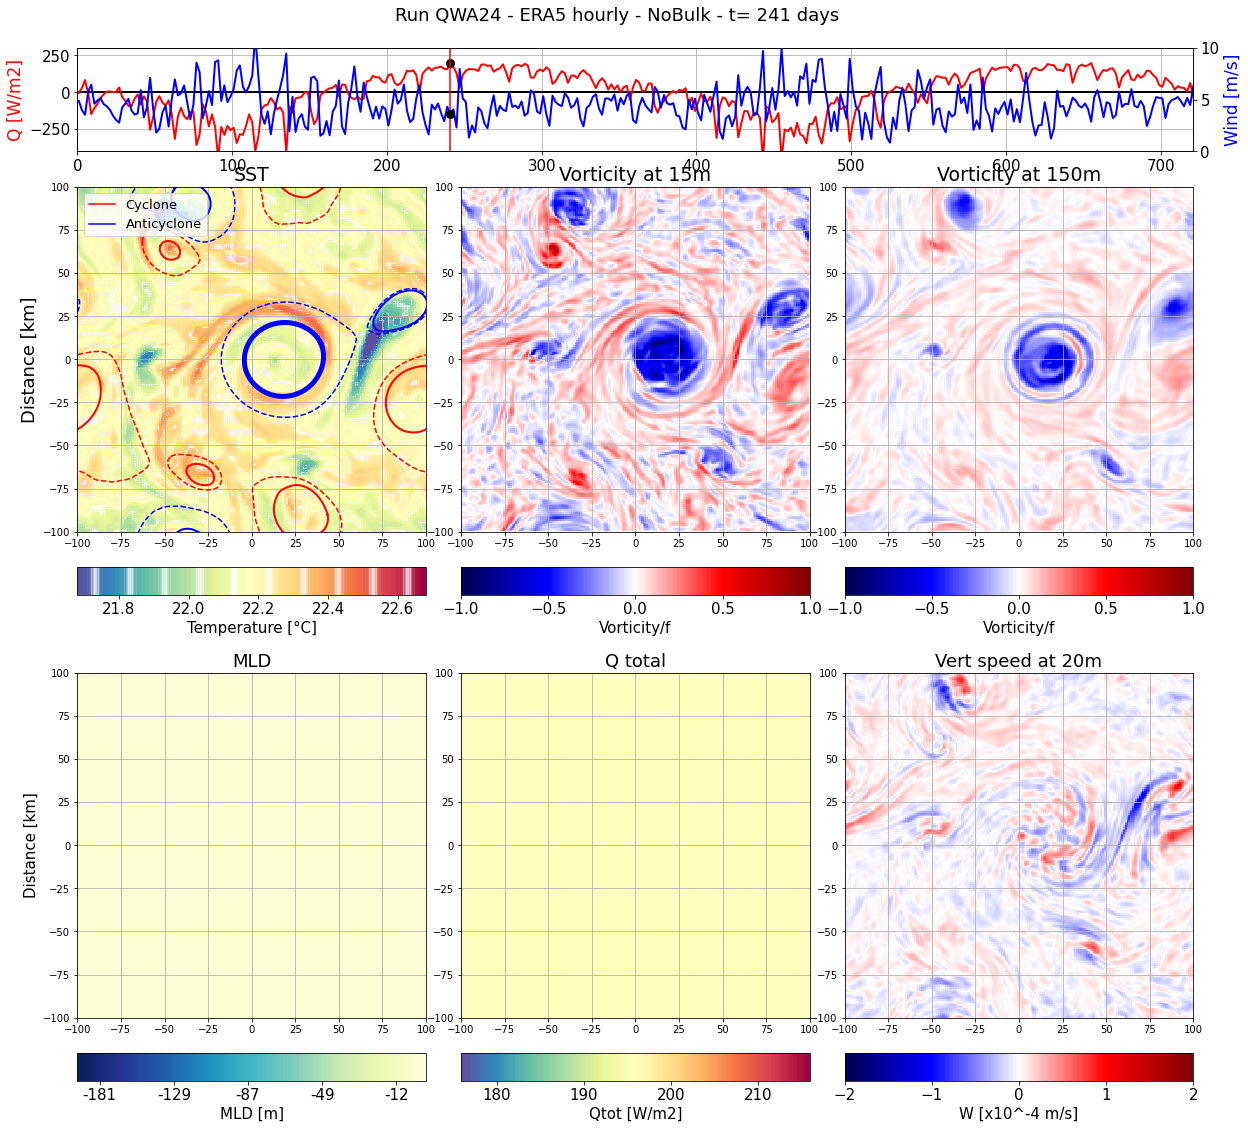

In [30]:
t=120 ; plot_number=False ; TS=15 ; LS=17
SSTticks=np.arange(SSTmean[t]-1.5-(SSTmean[t]-0.5)%1, SSTmean[t]+1.5-(SSTmean[t]-0.5)%1,0.2)

plt.figure(0, figsize=(20,19))
gs = GridSpec(6, 3, width_ratios=[1,1,1], height_ratios=[3,10,0.8,0.2,10,0.8], wspace=0.1, hspace=0.25)

ax1=plt.subplot(gs[0,:])    ### Q  (timeseries)
plt.plot([0,time[-1]],[0,0],'-k',lw=2)
plt.plot(time, Qmean,'-r', lw=2) ; plt.grid()
tf=np.argmin(np.abs(time-time[t]))
plt.plot(time[tf], Qmean[tf],'ok', ms=8)
plt.plot([time[tf]]*2, [-500,400],'-r')
plt.ylabel('Q [W/m2]',size=LS, color='r')
plt.ylim([-400,300]) ; plt.tick_params(labelsize=TS)

ax2=ax1.twinx()      ### Wind (timeseries)
ax2.plot(time, Wspeed,'-b',lw=2)
plt.plot(time[tf], Wspeed[tf],'ok', ms=8)
plt.ylabel('Wind [m/s]',size=LS, color='b')
plt.xlim([0,time[-1]]) ; plt.ylim([0,10])
plt.tick_params(labelsize=TS)

plt.subplot(gs[1,0]) ### SST
plt.pcolor(xi_rho,xi_rho,temp[t,-1,:,:],vmin=SSTmean[t]-0.5, vmax=SSTmean[t]+0.5,cmap=my_cmap)#cm.RdYlBu_r)#Spectral_r)
### Plotting AMEDA eddies
ListPs=np.where(StepEddy[:,t])[0]
for i in tqdm(range(len(ListPs))):
    if ListPs[i] in MainEddy:
        lw=5  ## THicker line for Main Eddy
    else:
        lw=2
    idt=np.where(D[tracks['step'][ListPs[i],0]][0]-1==t)[0]
    ### Plotting Rmax
    Contour=D[D[tracks['shapes1'][ListPs[i],0]][0][int(idt)]][:]
    plt.plot(Contour[:,0], Contour[:,1], '-', lw=lw, color=Color[ListPs[i]])
    ### Plotting Rend
    Contour=D[D[tracks['shapes3'][ListPs[i],0]][0][int(idt)]][:]
    plt.plot(Contour[:,0], Contour[:,1], '--', color=Color[ListPs[i]])
plt.title('SST', size=19)  
plt.plot([0,0],[0,0],'-r', label='Cyclone') ; plt.plot([0,0],[0,0],'-b', label='Anticyclone') ; plt.legend(loc=2, fontsize=13)
plt.xlim([-Xmax,Xmax]) ; plt.ylim([-Xmax,Xmax]) ; plt.grid() ; plt.ylabel('Distance [km]', size=18)
CB1=plt.colorbar(cax=plt.subplot(gs[2,0]), orientation='horizontal')
CB1.ax.set_xlabel(u'Temperature [\N{DEGREE SIGN}C]', fontsize=15)
CB1.ax.set_xlim([SSTmean[t]-0.5,SSTmean[t]+0.5])
CB1.set_ticks(list(SSTticks),[ '%0.2f'%x for x in SSTticks ])
CB1.ax.tick_params(labelsize=15)

plt.subplot(gs[1,1])  ### Vorticity (surf)
plt.pcolor(x_psi, y_psi, Vort[t,:], cmap=cm.seismic, vmin=-1, vmax=1)
plt.title('Vorticity at 15m', size=19)
plt.xlim([-Xmax,Xmax]) ; plt.ylim([-Xmax,Xmax]) ; plt.grid()
CB2=plt.colorbar(cax=plt.subplot(gs[2,1]), orientation='horizontal')
CB2.ax.set_xlabel('Vorticity/f', fontsize=15)
CB2.ax.tick_params(labelsize=15)

plt.subplot(gs[1,2])  ### Vorticity (intermed)
plt.pcolor(x_psi, y_psi, Vort_i[t,:], cmap=cm.seismic, vmin=-1, vmax=1)
plt.title('Vorticity at 150m', size=19)
plt.xlim([-Xmax,Xmax]) ; plt.ylim([-Xmax,Xmax]) ; plt.grid()
CB2=plt.colorbar(cax=plt.subplot(gs[2,2]), orientation='horizontal')
CB2.ax.set_xlabel('Vorticity/f', fontsize=15)
CB2.ax.tick_params(labelsize=15)

plt.subplot(gs[4,1])  #### Qtot map
plt.pcolor(xi_rho, xi_rho,qtot[t], cmap=cm.Spectral_r, vmin=Qmean[t]-20, vmax=Qmean[t]+20)  ; plt.grid()
plt.title('Q total',size=18) ;plt.ylabel('Distance',size=15)
CB=plt.colorbar(cax=plt.subplot(gs[5,1]), orientation='horizontal') ; 
CB.set_label('Qtot [W/m2]',size=15)
CB.ax.tick_params(labelsize=15)

plt.subplot(gs[4,2])  #### Vert speed map
plt.pcolor(xi_rho, xi_rho,W[t,-6]*1e4, cmap=cm.seismic, vmin=-2, vmax=2)  ; plt.grid()
plt.title('Vert speed at 20m',size=18) 
CB=plt.colorbar(cax=plt.subplot(gs[5,2]), orientation='horizontal') ; 
CB.set_label('W [x10^-4 m/s]',size=15)
CB.ax.tick_params(labelsize=15)

plt.subplot(gs[4,0])  #### MLD map
plt.pcolor(xi_rho, xi_rho,MLDind[t], vmin=np.argmin(np.abs(zvert+MLDmax)), vmax=Nvert, cmap=cm.YlGnBu_r)
plt.title('MLD',size=18) ;plt.ylabel('Distance [km]',size=15)  ; plt.grid()
CB=plt.colorbar(cax=plt.subplot(gs[5,0]), orientation='horizontal') ; 
ticks=CB.get_ticks()
f = interp.interp1d(np.arange(len(zvert)), zvert)
labels=['%3.0f'%(f(x)) for x in ticks]
CB.ax.set_xticks(ticks) ;  CB.ax.set_xticklabels(labels)
CB.ax.tick_params(labelsize=15) ; CB.set_label('MLD [m]',size=15)

plt.suptitle(str_title+' - t= '+str(int(time[t]))+' days', size=18, y=0.91)

## SST - Vort - MLD

100%|██████████| 48/48 [00:00<00:00, 208.43it/s]
<ipython-input-26-a8bc369be5ca>:64: UserWarning: Use the colorbar set_ticks() method instead.
  CB.ax.set_xticks(ticks) ;  CB.ax.set_xticklabels(labels)
<ipython-input-26-a8bc369be5ca>:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  CB.ax.set_xticks(ticks) ;  CB.ax.set_xticklabels(labels)


Text(0.5, 0.91, 'Run QWA45 - 4km ERA5 1-hour with SST retroaction - t= 301.0 days')

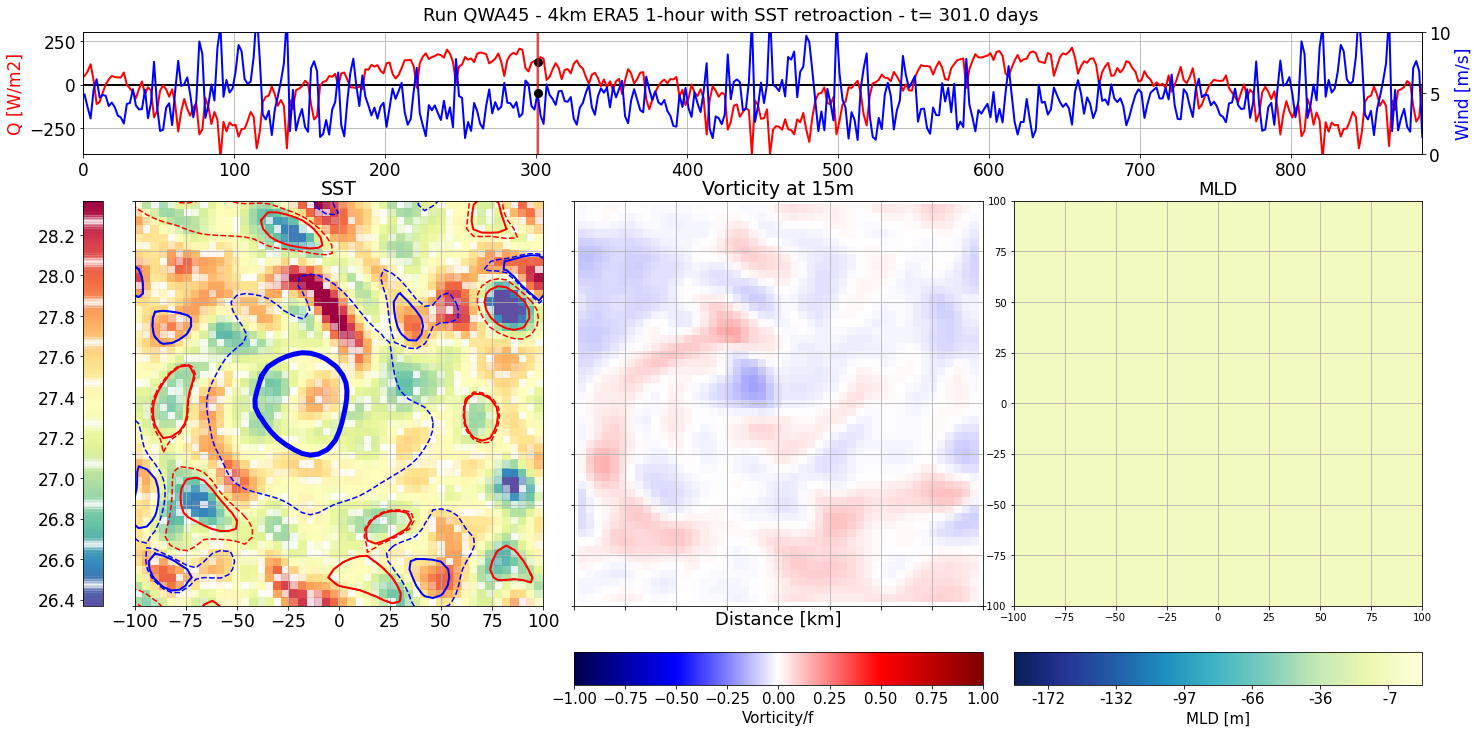

In [26]:
t=150 ; plot_number=False ; TS=17 ; LS=17 ; dTmax=1
SSTticks=np.arange(SSTmean_h[t]-dTmax-1-(SSTmean_h[t]-dTmax)%1, SSTmean_h[t]+dTmax+1-(SSTmean_h[t]-dTmax)%1,0.2)

plt.figure(0, figsize=(24,12))
gs = GridSpec(3, 4, width_ratios=[0.05,1,1,1], height_ratios=[3,10,0.8], wspace=0.1, hspace=0.25)

ax1=plt.subplot(gs[0,:])    ### Q  (timeseries)
plt.plot([0,time[-1]],[0,0],'-k',lw=2)
plt.plot(time, Qmean,'-r', lw=2) ; plt.grid()
tf=np.argmin(np.abs(time-time[t]))
plt.plot(time[tf], Qmean[tf],'ok', ms=8)
plt.plot([time[tf]]*2, [-500,400],'-r')
plt.ylabel('Q [W/m2]',size=LS, color='r')
plt.ylim([-400,300]) ; plt.tick_params(labelsize=TS)

ax2=ax1.twinx()      ### Wind (timeseries)
ax2.plot(time, Wspeed,'-b',lw=2)
plt.plot(time[tf], Wspeed[tf],'ok', ms=8)
plt.ylabel('Wind [m/s]',size=LS, color='b')
plt.xlim([0,time[-1]]) ; plt.ylim([0,10])
plt.tick_params(labelsize=TS)

plt.subplot(gs[1,1]) ### SST
plt.pcolor(xi_rho,xi_rho,temp_h[t,-1,:,:],vmin=SSTmean_h[t]-dTmax, vmax=SSTmean_h[t]+dTmax,cmap=my_cmap)#cm.RdYlBu_r)#Spectral_r)
### Plotting AMEDA eddies
ListPs=np.where(StepEddy[:,t])[0]
for i in tqdm(range(len(ListPs))):
    if ListPs[i] in MainEddy:
        lw=5  ## THicker line for Main Eddy
    else:
        lw=2
    idt=np.where(D[tracks['step'][ListPs[i],0]][0]-1==t)[0]
    ### Plotting Rmax
    Contour=D[D[tracks['shapes1'][ListPs[i],0]][0][int(idt)]][:]
    plt.plot(Contour[:,0], Contour[:,1], '-', lw=lw, color=Color[ListPs[i]])
    ### Plotting Rend
    Contour=D[D[tracks['shapes3'][ListPs[i],0]][0][int(idt)]][:]
    plt.plot(Contour[:,0], Contour[:,1], '--', color=Color[ListPs[i]])
plt.title('SST', size=19) ; plt.tick_params(labelleft=False, labelbottom=True, labelsize=TS)
plt.plot([0,0],[0,0],'-r', label='Cyclone') ; plt.plot([0,0],[0,0],'-b', label='Anticyclone') #; plt.legend(loc=2, fontsize=13)
plt.xlim([-Xmax,Xmax]) ; plt.ylim([-Xmax,Xmax]) ; plt.grid()
CB1=plt.colorbar(cax=plt.subplot(gs[1,0]))#, orientation='horizontal')
#CB1.ax.set_ylabel(u'Temperature [\N{DEGREE SIGN}C]', fontsize=15)
CB1.ax.set_ylim([SSTmean_h[t]-dTmax,SSTmean_h[t]+dTmax])
CB1.set_ticks(list(SSTticks),[ '%0.2f'%x for x in SSTticks ])
CB1.ax.tick_params(labelsize=TS, left=True, right=False, labelleft=True, labelright=False)

plt.subplot(gs[1,2])  ### Vorticity (surf)
plt.pcolor(x_psi, y_psi, Vort[t,:], cmap=cm.seismic, vmin=-1, vmax=1)
plt.title('Vorticity at 15m', size=19)  ; plt.xlabel('Distance [km]', size=18)
plt.xlim([-Xmax,Xmax]) ; plt.ylim([-Xmax,Xmax]) ; plt.grid()
plt.tick_params(labelleft=False, labelbottom=False)
CB2=plt.colorbar(cax=plt.subplot(gs[2,2]), orientation='horizontal')
CB2.ax.set_xlabel('Vorticity/f', fontsize=15)
CB2.ax.tick_params(labelsize=15)

plt.subplot(gs[1,3])  #### MLD map
plt.pcolor(xi_rho, xi_rho,MLDind_h[t], vmin=np.argmin(np.abs(zvert+MLDmax)), vmax=Nvert, cmap=cm.YlGnBu_r)
plt.title('MLD',size=18) ; plt.grid()
CB=plt.colorbar(cax=plt.subplot(gs[2,3]), orientation='horizontal') ; 
ticks=CB.get_ticks()
f = interp.interp1d(np.arange(len(zvert)), zvert)
labels=['%3.0f'%(f(x)) for x in ticks]
CB.ax.set_xticks(ticks) ;  CB.ax.set_xticklabels(labels)
CB.ax.tick_params(labelsize=15) ; CB.set_label('MLD [m]',size=15)

plt.suptitle(str_title+' - t= '+'%3.1f'%time_h[t]+' days', size=18, y=0.91)

## SST + Vort + NuTurb plot

100%|██████████| 13/13 [00:00<00:00, 272.59it/s]


Text(0.5, 0.91, 'Run QWA8 / 1km ERA5 No Bulk - t= 560 days')

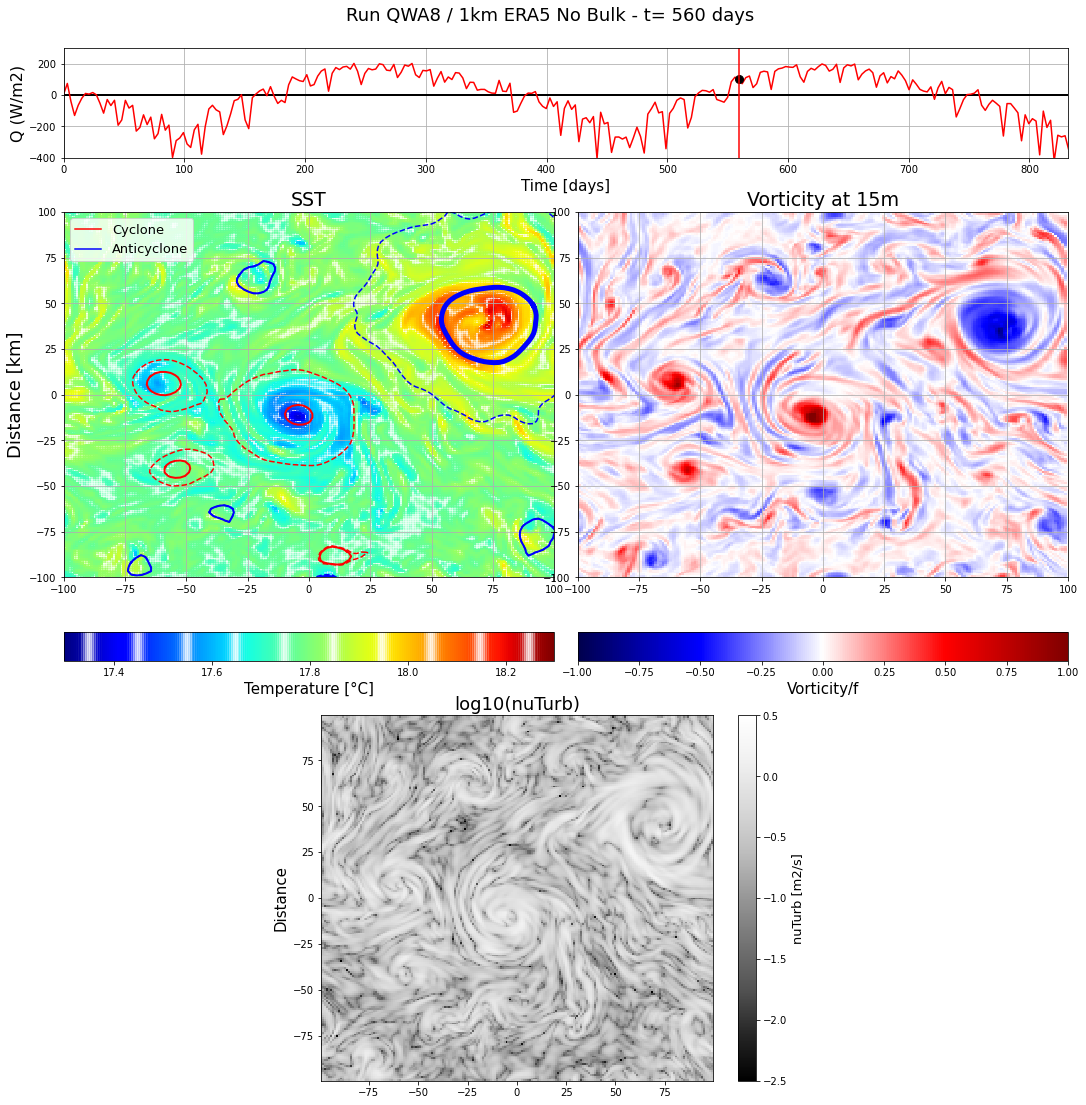

In [31]:
t=280
SSTticks=np.arange(SSTmean_h[t]-1.5-(SSTmean_h[t]-0.5)%1, SSTmean_h[t]+1.5-(SSTmean_h[t]-0.5)%1,0.2)

plt.figure(0, figsize=(18,19))
gs = GridSpec(4, 4, width_ratios=[4,4,4,4], height_ratios=[3,10,0.8,10], wspace=0.1, hspace=0.25)

### SST
plt.subplot(gs[1,:2])
plt.pcolor(xi_rho,xi_rho,temp_h[t,-1,:,:],vmin=SSTmean_h[t]-0.5, vmax=SSTmean_h[t]+0.5,cmap=my_cmap)#cm.RdYlBu_r)#Spectral_r)

### Plotting AMEDA eddies
ListPs=np.where(StepEddy[:,t])[0]
for i in tqdm(range(len(ListPs))):
    if ListPs[i] in MainEddy:
        lw=5  ## THicker line for Main Eddy
    else:
        lw=2
    idt=np.where(D[tracks['step'][ListPs[i],0]][0]-1==t)[0]
    ### Plotting Rmax
    Contour=D[D[tracks['shapes1'][ListPs[i],0]][0][int(idt)]][:]
    plt.plot(Contour[:,0], Contour[:,1], '-', lw=lw, color=Color[ListPs[i]])
    ### Plotting Rend
    Contour=D[D[tracks['shapes3'][ListPs[i],0]][0][int(idt)]][:]
    plt.plot(Contour[:,0], Contour[:,1], '--', color=Color[ListPs[i]])

plt.title('SST', size=19)  
plt.plot([0,0],[0,0],'-r', label='Cyclone') ; plt.plot([0,0],[0,0],'-b', label='Anticyclone') ; plt.legend(loc=2, fontsize=13)
plt.xlim([-Xmax,Xmax]) ; plt.ylim([-Xmax,Xmax]) ; plt.grid() ; plt.ylabel('Distance [km]', size=18)
CB1=plt.colorbar(cax=plt.subplot(gs[2,:2]), orientation='horizontal')
CB1.ax.set_xlabel(u'Temperature [\N{DEGREE SIGN}C]', fontsize=15)
CB1.ax.set_xlim([SSTmean[t]-0.5,SSTmean[t]+0.5])
CB1.set_ticks(list(SSTticks),[ '%0.2f'%x for x in SSTticks ])

plt.subplot(gs[1,2:])  ### Vorticity
plt.pcolor(x_psi, y_psi, Vort[t,:], cmap=cm.seismic, vmin=-1, vmax=1)
plt.title('Vorticity at 15m', size=19)
plt.xlim([-Xmax,Xmax]) ; plt.ylim([-Xmax,Xmax]) ; plt.grid()
CB2=plt.colorbar(cax=plt.subplot(gs[2,2:]), orientation='horizontal')
CB2.ax.set_xlabel('Vorticity/f', fontsize=15)

plt.subplot(gs[0,:])    ### Q 
plt.plot([0,time[-1]],[0,0],'-k',lw=2)
plt.plot(dayflux, STFday,'-r') ; plt.grid()
plt.xlabel('Time [days]',size=15)
tf=np.argmin(np.abs(dayflux-time[t]))
plt.plot(dayflux[tf], STFday[tf],'ok', ms=8)
plt.plot([dayflux[tf]]*2, [-400,300],'-r')
plt.ylabel('Q (W/m2)',size=16)
plt.xlim([0,time[-1]]) ; plt.ylim([-400,300])

plt.subplot(gs[3,1:3])  #### nuTurb map
plt.pcolor(x_psi, y_psi,np.log10(nuT[t]), vmin=-2.5, vmax=0.5, cmap=cm.Greys_r)
plt.title('log10(nuTurb)',size=18) ;plt.ylabel('Distance',size=15)
CB=plt.colorbar()#cax=plt.subplot(gs[3,3])) ; 
CB.set_label('nuTurb [m2/s]',size=13)

plt.suptitle(str_title+' - t= '+str(int(time[t]))+' days', size=18, y=0.91)

## SST & Vorticity movie

In [42]:
path_save='../Analysis/QWC5_SST_Vspeed/'
path_save

'../Analysis/QWC5_SST_Vspeed/'

In [52]:
plot_number=False ; dTmax=0.5
f = interp.interp1d(np.arange(len(zvert)), zvert)
T0=25 ; R0=26 ; Tcoef=0.28    ### Translating temperature to density
Levels=np.array(list(np.arange(25.5,27,0.2))+list(np.arange(27.1,29.2,0.1)))
Levels_v=np.arange(-1,1.1,0.2)
mode = 'plain' # 'plain' or 'anom'

#IDY=np.zeros(Nh)    ### For .npy storage
#SIGMA=np.zeros((Nh,Nvert,Nx))
#Vort_sect=np.zeros((Nh,Nvert,Nx-1))
#QPV=np.zeros((Nh,Nvert-1,Nx-1))

for t in tqdm(range(10,200,2)):
    ### Takes into consideration if "multiple Main" => takes the first one
    ted=np.argmin(np.abs(timeeddy-time_h[t]))
    idy=np.argmin(np.abs(xi_rho-Y1[ted]))

    SSTticks=np.arange(SSTmean_h[t]-1.5-(SSTmean_h[t]-0.5)%1, SSTmean_h[t]+1.5-(SSTmean_h[t]-0.5)%1,0.2)
    Sigma=R0-Tcoef*(temp_h[t,:,idy]-T0) ; Buoy= -9.81 * Sigma/1026
    #### Figure 
    plt.figure(0, figsize=(18,22))
    gs = GridSpec(4, 4, width_ratios=[2,10,10,1], height_ratios=[3,10,0.5,10], wspace=0.1, hspace=0.15)

    plt.subplot(gs[1,:2])  ### MLD
    CP=plt.pcolor(xi_rho, xi_rho,MLDind_h[t], vmin=np.argmin(np.abs(zvert+MLDmax)) , vmax=len(zvert), cmap=cm.YlGnBu_r)
    plt.plot(X1[ted],Y1[ted],'ok',mec='w',ms=10)
    plt.plot([-Xmax,Xmax],[xi_rho[idy]]*2,'-k',lw=3)
    plt.title('MLD',size=18); plt.grid()# ;plt.ylabel('Distance [km]',size=15)  
    plt.tick_params(labelsize=TS)
    CB=plt.colorbar(CP,cax=plt.subplot(gs[2,:2]), orientation='horizontal') ; 
    CB.ax.tick_params(labelsize=15) ; CB.set_label('MLD [m]',size=15)
    ticks=CB.get_ticks()
    labels=['%3.0f'%(f(x)) for x in ticks]
    CB.ax.set_xticklabels(labels)

    plt.subplot(gs[1,2:])  ### SST
    plt.pcolor(xi_rho,xi_rho,temp_h[t,-1,:,:],vmin=SSTmean_h[t]-dTmax, vmax=SSTmean_h[t]+dTmax,cmap=my_cmap)#cm.RdYlBu_r)#Spectral_r)
    ListPs=np.where(StepEddy[:,t])[0] ### Plotting AMEDA eddies
    for i in tqdm(range(len(ListPs))):
        if ListPs[i] in MainEddy:
            lw=5  ## THicker line for Main Eddy
        else:
            lw=2
        idt=np.where(D[tracks['step'][ListPs[i],0]][0]-1==t)[0]
        Contour=D[D[tracks['shapes1'][ListPs[i],0]][0][int(idt)]][:]  ### Plotting Rmax
        plt.plot(Contour[:,0], Contour[:,1], '-', lw=lw, color=Color[ListPs[i]])
        Contour=D[D[tracks['shapes3'][ListPs[i],0]][0][int(idt)]][:]  ### Plotting Rend
        plt.plot(Contour[:,0], Contour[:,1], '--', color=Color[ListPs[i]])
    plt.xlim([-Xmax-1,Xmax]) ; plt.ylim([-Xmax,Xmax]) ; plt.grid()
    plt.tick_params(labelleft=False,labelsize=TS)
    plt.title('SST', size=19)
    CB1=plt.colorbar(cax=plt.subplot(gs[2,2:]), orientation='horizontal')
    CB1.ax.set_xlabel(u'Temperature [\N{DEGREE SIGN}C]', fontsize=LS)
    CB1.ax.set_xlim([SSTmean_h[t]-dTmax,SSTmean_h[t]+dTmax])
    CB1.set_ticks(list(SSTticks),[ '%0.2f'%x for x in SSTticks ])
    CB1.ax.tick_params(labelsize=TS)

    ax1=plt.subplot(gs[0,:])    ### Q 
    plt.plot([0,time[-1]],[0,0],'-k',lw=2)
    plt.plot(time, Qmean,'-r', lw=2) ; plt.grid()
    tf=np.argmin(np.abs(time-time_h[t]))
    plt.plot(time[tf], Qmean[tf],'ok', ms=8)
    plt.plot([time[tf]]*2, [-500,400],'-r')
    plt.ylabel('Q [W/m2]',size=LS, color='r')
    plt.ylim([-400,300]) ; plt.tick_params(labelsize=TS)

    ax2=ax1.twinx()      ### Wind
    ax2.plot(time, Wspeed,'-b',lw=2)
    plt.plot(time[tf], Wspeed[tf],'ok', ms=8)
    plt.ylabel('Wind [m/s]',size=LS, color='b')
    plt.xlim([0,time[-1]]) ; plt.ylim([0,10])
    plt.tick_params(labelsize=TS)

    plt.subplot(gs[3,1:3])  ### PV Section
    #CP3=plt.pcolor(xi_psi, zs, qpv, cmap=cm.seismic, vmin=Levels_v[0]/10, vmax=Levels_v[-1]/10)
    CP3=plt.contourf(xi_rho, zvert, V_f[t,:,idy],np.arange(-0.2,0.21,0.02), cmap=cm.seismic,extend='both')
    CP4=plt.contour(xi_rho, zvert, V_f[t,:,idy],21,  colors=['gray'], vmin=-0.2, vmax=0.2)
    CP2=plt.contour(xi_rho, zvert, Sigma, colors=['k'],levels=Levels)
    plt.clabel(CP2, Levels, fmt='%3.1f')
    plt.tick_params(labelsize=TS)
    plt.xlim([-Xmax,Xmax]) ; plt.ylim([-250,0]) ; plt.grid()
    plt.ylabel('Depth [m]',size=LS) ; plt.xlabel('Distance [km]',size=LS)
    plt.plot([0,0],[0,0],'-k',lw=2, label='Isopycnals') ; plt.legend(loc=4,fontsize=LS)
    CB2=plt.colorbar(CP3, cax=plt.subplot(gs[3,3]), orientation='vertical')
    CB2.ax.set_ylabel('Meridional Speed [m/s]', fontsize=LS) ; CB2.ax.tick_params(labelsize=TS)

    plt.suptitle(str_title+' - t= '+str(int(time[t]))+' days', size=18, y=0.91)
############
    plt.tight_layout()
    plt.savefig(path_save+'SST_V_t='+'%4.0f'%(time_h[t]*10)+'.png')
    plt.close()

  0%|          | 0/95 [00:00<?, ?it/s]<ipython-input-52-c7b6d0c5edd6>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  CB.ax.set_xticklabels(labels)

100%|██████████| 2/2 [00:00<00:00, 236.47it/s]
<ipython-input-52-c7b6d0c5edd6>:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
  1%|          | 1/95 [00:02<03:44,  2.39s/it]<ipython-input-52-c7b6d0c5edd6>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  CB.ax.set_xticklabels(labels)

100%|██████████| 2/2 [00:00<00:00, 239.16it/s]
<ipython-input-52-c7b6d0c5edd6>:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
  2%|▏         | 2/95 [00:04<03:08,  2.02s/it]<ipython-input-52-c7b6d0c5edd6>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  CB.ax.set_xticklabels(labels)

100%


100%|██████████| 7/7 [00:00<00:00, 259.02it/s]
<ipython-input-52-c7b6d0c5edd6>:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 22%|██▏       | 21/95 [00:44<02:18,  1.88s/it]<ipython-input-52-c7b6d0c5edd6>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  CB.ax.set_xticklabels(labels)

100%|██████████| 7/7 [00:00<00:00, 259.32it/s]
<ipython-input-52-c7b6d0c5edd6>:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 23%|██▎       | 22/95 [00:46<02:13,  1.82s/it]<ipython-input-52-c7b6d0c5edd6>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  CB.ax.set_xticklabels(labels)

100%|██████████| 12/12 [00:00<00:00, 264.69it/s]
<ipython-input-52-c7b6d0c5edd6>:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might

 63%|██████▎   | 60/95 [01:57<01:08,  1.95s/it]<ipython-input-52-c7b6d0c5edd6>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  CB.ax.set_xticklabels(labels)

100%|██████████| 24/24 [00:00<00:00, 265.19it/s]
<ipython-input-52-c7b6d0c5edd6>:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 64%|██████▍   | 61/95 [01:59<01:05,  1.92s/it]<ipython-input-52-c7b6d0c5edd6>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  CB.ax.set_xticklabels(labels)

100%|██████████| 11/11 [00:00<00:00, 260.16it/s]
<ipython-input-52-c7b6d0c5edd6>:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 65%|██████▌   | 62/95 [02:01<01:02,  1.88s/it]<ipython-input-52-c7b6d0c5edd6>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  CB.ax.set_xticklabel


100%|██████████| 32/32 [00:00<00:00, 255.11it/s]
<ipython-input-52-c7b6d0c5edd6>:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 83%|████████▎ | 79/95 [02:35<00:30,  1.93s/it]<ipython-input-52-c7b6d0c5edd6>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  CB.ax.set_xticklabels(labels)

100%|██████████| 38/38 [00:00<00:00, 257.05it/s]
<ipython-input-52-c7b6d0c5edd6>:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 84%|████████▍ | 80/95 [02:37<00:28,  1.93s/it]<ipython-input-52-c7b6d0c5edd6>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  CB.ax.set_xticklabels(labels)

100%|██████████| 42/42 [00:00<00:00, 257.75it/s]
<ipython-input-52-c7b6d0c5edd6>:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results m

## Saving .npy

In [31]:
path_save='../Analysis/'
DictV={}
DictV['qpv']=QPV
DictV['Sigma']=SIGMA
DictV['Vort_sect']=Vort_sect
DictV['z_dz']=zs
DictV['zvert']=zvert
DictV['idy']=IDY
DictV['MLD']=MLDind_h
np.save(path_save+'PV+Vort_'+expname.upper()+'.npy', DictV)

In [29]:
moviename='QWA45_SST_MLD'
path_save='../Analysis/QWA45_SST/'
path_save

'../Analysis/QWA45_SST/'

In [30]:
"""
Quick and dirty script for .mp4 using imageio
"""
import imageio
import os

"""
Create .mp4 from series of pictures stored at path dir_fig,
Change filename loop for picture selection, picture name or extension (.png /.jpg /.tif)

Default fps should be 12, make additional operations using FFMPEG in the terminal
Command line to slow down by a factor of 8:
$ ffmpeg  -i input.mp4 -vf  "setpts=8*PTS" output_slow.mp4

Code can be reused to produce .gif
"""
kargs = { 'macro_block_size': None }#, 'ffmpeg_params': [ '-r', '12']}

filelist=os.listdir(path_save)
filelist=np.sort(filelist)
if filelist[0]=='.ipynb_checkpoints':
    filelist=filelist[1:] #to remove '.ipynb_checkpoints'
images = []

for k in tqdm(range(len(filelist))):
    filename=path_save+filelist[k]  ###   <========== CHANGE FILENAME HERE #######
    images.append(imageio.imread(filename))
   
imageio.mimwrite(path_save+'../Movies/'+moviename+'.mp4', images, 'MP4', fps=2)#**kargs)   ####  <===== Change movie.mp4 name here
#imageio.mimsave(dir_fig+'Tmax-Temp-SLA_scatter+Bin_'+str(YEAR[0])+'-'+str(YEAR[-1])+'.gif', images, fps=1)

100%|██████████| 304/304 [00:17<00:00, 17.00it/s]


## Following Max SSH as center on Psi grid

In [26]:
max_x=np.zeros(len(time)) ; max_y=np.zeros(len(time))
for i in range(len(time)):
    max_x[i]=np.where(np.abs(zeta[i])==np.max(np.abs(zeta[i])))[0][0]
    max_y[i]=np.where(np.abs(zeta[i])==np.max(np.abs(zeta[i])))[1][0]
max_x=max_x.astype(int)
max_y=max_y.astype(int)
plt.xlim([-Xmax,Xmax]) ; plt.ylim([-Xmax,Xmax])
x1psi=xi_rho[max_y[:]] ; y1psi=xi_rho[max_x[:]]
plt.plot(x1psi,y1psi,'-k')

NameError: name 'zeta' is not defined

In [31]:
def r_theta_from_xy(x_p, y_p): 
    r=np.sqrt(x_p**2+y_p**2)
    theta=np.zeros(np.shape(x_p))
    theta[x_p!=0]=np.arctan(y_p[x_p!=0]/x_p[x_p!=0])
    theta[(x_p==0)&(y_p<0)]=-np.pi/2
    theta[(x_p==0)&(y_p>0)]=np.pi/2
    theta[x_p<0]=theta[x_p<0]+np.pi
    theta=theta%(np.pi*2)
    return r, theta

In [51]:
np.shape(W[t,-6]); np.shape(rloc)
np.shape(x_psi)

(199, 199)

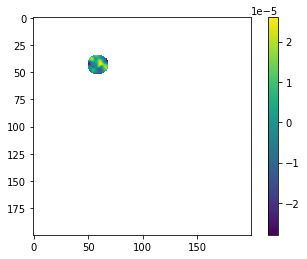

In [53]:
t=200 ; Rm=20
#x_psiloc=x_psi-x1psi[t]  ### If following Max Zeta
#y_psiloc=y_psi-y1psi[t]
x_psiloc=x_psi-X1[t]      ### If AMEDA tracking available PSI grid
y_psiloc=y_psi-Y1[t]
x_rholoc=x_rho-X1[t]      ### If AMEDA tracking available RHO grid
y_rholoc=y_rho-Y1[t] 

#rloc, thetaloc=r_theta_from_xy(x_psiloc, y_psiloc)
#ModeSin=Vort[t]      ### for Vorticity #*np.cos(0*thetaloc)

rloc, thetaloc=r_theta_from_xy(x_rholoc, y_rholoc)
ModeSin=W[t,-6]      ### for Vertical speed

ModeSin[rloc>Rm]=np.nan
plt.imshow(ModeSin, cmap=cm.seismic, vmin=) ; plt.colorbar()

In [54]:
np.nanmean(ModeSin)

1.658705e-06

In [55]:
ModeMax=5 ; Rm=20
ModeT=np.zeros((len(time),ModeMax))

for t in tqdm(range(324)):#len(time))):
    #x_psiloc=x_psi-x1psi[t]  ### If following Max Zeta
    #y_psiloc=y_psi-y1psi[t]
    #x_psiloc=x_psi-X1[t]      ### If AMEDA tracking available
    #y_psiloc=y_psi-Y1[t]
    #rloc, thetaloc=r_theta_from_xy(x_psiloc, y_psiloc)
    
    x_rholoc=x_rho-X1[t]      ### If AMEDA tracking available RHO grid
    y_rholoc=y_rho-Y1[t] 
    rloc, thetaloc=r_theta_from_xy(x_rholoc, y_rholoc)

    VortLoc=np.copy(Vort[t])
    VortLoc=np.copy(W[t,-6])
    ## Important to focus on anticyclone
    VortLoc[rloc>Rm]=np.nan;
    #Vt[~MaskPsi[i]]=np.nan

    for k in range(len(ModeT[0])):
        ## Projection on 2 phases
        ModeCos=VortLoc*np.cos(k*thetaloc) ; ModeSin=VortLoc*np.sin(k*thetaloc)
        ## Module
        ModeT[t,k]=np.sqrt((np.nansum(ModeCos))**2+(np.nansum(ModeSin))**2)
        
## Normalisation 
dA=np.diff(xi_rho)[0]**2
Norm=int(np.pi*Rm**2/dA)  ## not exactly correct but fairly good, see len(np.where(rloc<Rmax)[0])
ModeTN=ModeT/Norm

100%|██████████| 324/324 [00:05<00:00, 54.82it/s]


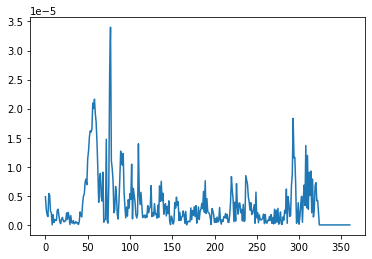

In [56]:
plt.plot(ModeTN[:,0])

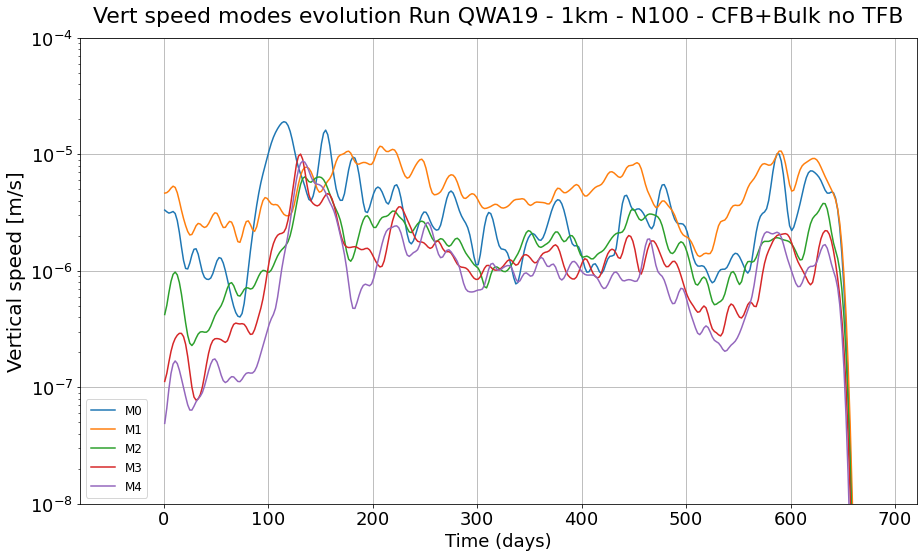

In [65]:
## Plot distrubance evolution
plt.figure(100, figsize=(15,12))
gs = GridSpec(2, 1, height_ratios=[3,1], hspace=0.1)

plt.subplot(gs[0])
for i in range(ModeMax):
    #plt.plot(timeeddy, ModeTN[:,i],'-', label='Mode '+str(i))
    #plt.plot(time, ModeTN[:,i],'-', label='Mode '+str(i))
    plt.plot(time,nd.gaussian_filter1d(ModeTN[:,i],sigma=2),'-', label='M'+str(i))
plt.tick_params(labelsize=18)
#plt.ylabel('Vorticity per mode \n (normalized by f)', size=20)
plt.ylabel('Vertical speed [m/s]', size=20)

plt.ylim([1e-8,1e-4]) ; 

plt.xlim([-80,time[-1]])
plt.grid() ; plt.legend(fontsize=12,loc=3) ; plt.yscale('log')
plt.title('Vert speed modes evolution '+str_title, size=22, y=1.02)
plt.xlabel('Time (days)', size=18) ;
plt.savefig('/home6/datahome/abarboni/CROCO/Analysis/Aeref7_Modes.png')

#plt.subplot(gs[1])
#plt.plot(time, Q,'-r'); plt.grid()
#plt.ylabel('Q (W/m2)',size=16)
#plt.xlim([-50,time[-1]])
#plt.tick_params(labelsize=18)
#plt.xlabel('Time (days)', size=18) ;